## **Setup**

Imports, constants, helpers and loads


In [1]:
# Core
import numpy as np

# SciPy
from scipy.interpolate import interp1d

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

# Project modules
from modules.conversion import plasma_freq

from modules.planet_env import JUPITER_ENV, EARTH_ENV, SUN_ENV

from modules.noise import (
    galactic_background,
    brightness_qtn_earth,
    brightness_qtn_jupiter,
    brightness_qtn_sun,
    ma_to_freq,
    freq_to_ma,
    DEFAULT_L_EFF,
)



In [2]:
# Plot settings

plot_factor = 2

font_size =  plot_factor * 9
column_width =  plot_factor * 3.375  # in inches

lw_fixed = plot_factor * 1
s_fixed = plot_factor * 80 

fig_width = column_width  
fig_height = fig_width * 0.75  

In [3]:
plt.rcParams.update({
    "text.usetex": True,           # Enable LaTeX rendering
    "font.size": font_size,        # Set the general font size
    "axes.titlesize": font_size,   # Set the axes title font size
    "axes.labelsize": font_size,   # Set the axes label font size
    "xtick.labelsize": font_size,  # Set the x tick label font size
    "ytick.labelsize": font_size,  # Set the y tick label font size
    "legend.fontsize": font_size,  # Set the legend font size
    "figure.titlesize": font_size, # Set the figure title font size
    "font.family": "serif",        # Use serif fonts
    "text.latex.preamble": r"\usepackage{amsmath}"  # Use AMS math package for consistency
})


In [4]:
# Constants & unit conversions from project modules
from modules.constants import (MeterToInveV, SecondToInveV, KelvinToeV, JouleToeV, GaussToSqrdeV,
    alpha,
)
from modules.conversion import C_SI
from modules.noise import Z0_OHM

Z0 = Z0_OHM  # Impedance of free space in Ohms
k_B = 1.380649e-23          # J/K
pol_factor_SEFD = 2  # Polarization factor for SEFD calculations

# Distances used in this notebook
D_4AU = 4 * 1.496e11  # 4 AU in meters
D_L2 = 1 * 1.5e9      # L2 from Earth in meters
D_1AU = 1 * 1.496e11   # 1 AU in meters

D_RPW = 0.28 * 1.496e+11  # 0.28 AU in meters
D_PSP = 0.046 * 1.496e+11  # 0.046 AU in meters

R_J_meter = JUPITER_ENV.radius_m # Jupiter radius in meters
R_e_meter = EARTH_ENV.radius_m # Earth radius in meters
R_sun_meter = SUN_ENV.radius_m # Sun radius in meters

D_JUNO = 1.1 * R_J_meter
D_CASSINI = 137 * R_J_meter

### Helpers

In [5]:
# ==========================
# Helper functions
# ==========================

def loginterp(x_new, x, y):
    """Log-log interpolation."""
    return 10.0**np.interp(np.log10(x_new), np.log10(x), np.log10(y))

def n_points_for_ratio(fmin, fmax, r):
    """Number of multiplicative steps to span [fmin, fmax] with ratio r."""
    return int(np.floor(np.log(fmax / fmin) / np.log(r))) + 1

def sort_and_dedup(data, how="last"):
    """
    Sort an Nx2 array by x and remove duplicates.
    how: 'last', 'first', or 'mean'.
    """
    data_sorted = data[data[:, 0].argsort()]
    if how == "mean":
        x_unique = np.unique(data_sorted[:, 0])
        y_means = [data_sorted[data_sorted[:, 0] == x, 1].mean() for x in x_unique]
        return np.column_stack([x_unique, y_means])

    _, idx = np.unique(data_sorted[:, 0], return_index=True)
    if how == "last":
        _, idx = np.unique(data_sorted[::-1, 0], return_index=True)
        idx = data_sorted.shape[0] - 1 - idx
    return data_sorted[np.sort(idx)]

def compute_sensitivity_curve(x_instr, y_instr, M_grid, coupling_grid, F_grid):
    """
    Compute sensitivity curve in (m, g) or (m, eps) space.
    """
    sens_curve = []
    for m_req, phi_req in zip(x_instr, y_instr):
        col = np.abs(M_grid[0, :] - m_req).argmin()
        flux_1d = F_grid[:, col]
        coup_1d = coupling_grid[:, col]
        f_log = interp1d(np.log10(flux_1d), np.log10(coup_1d),
                         bounds_error=False, fill_value="extrapolate")
        sens_curve.append(10**f_log(np.log10(phi_req)))
    return np.array(sens_curve)

def rescale_with_rc(F_ref, D_ref_m, D_new_m, rc_vals_m, mask_ref=None):
    """
    Rescale Fν from D_ref_m to D_new_m, enforcing d > r_c(m).
    """
    F_new = np.full_like(F_ref, np.nan)
    valid_new = D_new_m > rc_vals_m
    valid_ref = np.ones_like(valid_new, dtype=bool) if mask_ref is None else mask_ref

    cols_ok = np.where(valid_ref & valid_new)[0]
    if cols_ok.size > 0:
        F_new[:, cols_ok] = F_ref[:, cols_ok] * (D_ref_m / D_new_m)**2

    return F_new, valid_new

def read_horizons_delta(filename, R_meter, N):
    """
    Read 'delta' column from HORIZONS file and keep values within N * R_meter.
    """
    delta_vals = []
    in_table = False

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('$$SOE'):
                in_table = True
                continue
            if line.startswith('$$EOE'):
                break
            if in_table and line:
                parts = line.split()
                try:
                    delta_au = float(parts[8])
                    d_m = delta_au * D_1AU
                    if d_m < N * R_meter:
                        delta_vals.append(d_m)
                except (IndexError, ValueError):
                    continue

    return np.array(delta_vals)


### Load flux grids


In [6]:
data_sun = np.load("grids/flux_grids_sun_compact.npz")
data_jupiter = np.load("grids/flux_grids_jupiter_compact.npz")
data_earth = np.load("grids/flux_grids_earth_compact.npz")

grids = {
    "sun": data_sun,
    "jupiter": data_jupiter,
    "earth": data_earth,
}

# Keep original variable names used later in the notebook
m_a_vals = data_sun["m_a_vals"]
g_vals = data_sun["g_vals"]
epsilon_vals = data_sun["epsilon_vals"]

m_a_vals_jupiter = data_jupiter["m_a_vals"]
g_vals_jupiter = data_jupiter["g_vals"]
epsilon_vals_jupiter = data_jupiter["epsilon_vals"]

m_a_vals_earth = data_earth["m_a_vals"]
g_vals_earth = data_earth["g_vals"]
epsilon_vals_earth = data_earth["epsilon_vals"]

# Meshgrids (match previous naming)
M_sun, G_sun = np.meshgrid(m_a_vals, g_vals, indexing="xy")
M_DP_sun, E_sun = np.meshgrid(m_a_vals, epsilon_vals, indexing="xy")

M_jupiter, G_jupiter = np.meshgrid(m_a_vals_jupiter, g_vals_jupiter, indexing="xy")
M_DP_jupiter, E_jupiter = np.meshgrid(m_a_vals_jupiter, epsilon_vals_jupiter, indexing="xy")

M_earth, G_earth = np.meshgrid(m_a_vals_earth, g_vals_earth, indexing="xy")
M_DP_earth, E_earth = np.meshgrid(m_a_vals_earth, epsilon_vals_earth, indexing="xy")

# rc values (meters); keep names expected later
rc_vals_sun = data_sun.get("rc_vals")
rc_vals_jupiter = data_jupiter.get("rc_vals")
rc_vals_earth = data_earth.get("rc_vals")

# Flux grids
F_axion_sun = data_sun["F_axion"]
F_dp_sun = data_sun["F_dp"]
F_axion_jupiter = data_jupiter["F_axion"]
F_dp_jupiter = data_jupiter["F_dp"]
F_axion_earth = data_earth["F_axion"]
F_dp_earth = data_earth["F_dp"]

# Reference distances / bandwidths stored with grids
D_ref_sun = data_sun.get("distance_m")
D_ref_jupiter = data_jupiter.get("distance_m")
D_ref_earth = data_earth.get("distance_m")
bandwidth_ref = data_sun.get("bandwidth_hz")


## **Galactic and QTN Brightness**

In [7]:
# Use noise models with target-aware QTN
def Brightness_Gal(ma_eV):
    return galactic_background(ma_eV)

def Brightness_QTN(
    ma_eV,
    target="earth",
    r_Rsun=None,
    r_AU=None,
    T_K=None,
    n_cm3=None,
    L_meter=DEFAULT_L_EFF,
):
    """Target-aware QTN wrapper (earth=1 AU, jupiter=5 AU, sun=radial)."""
    if target == "sun":
        return brightness_qtn_sun(ma_eV, r_Rsun=r_Rsun, r_AU=r_AU, T_K=T_K, L_meter=L_meter)
    if target == "jupiter":
        return brightness_qtn_jupiter(ma_eV, L_meter=L_meter)
    # default: Earth 1 AU
    return brightness_qtn_earth(ma_eV, L_meter=L_meter)

def Brightness_SKY(
    ma_eV,
    target="earth",
    r_Rsun=None,
    r_AU=None,
    T_K=None,
    n_cm3=None,
    L_meter=DEFAULT_L_EFF,
):
    return Brightness_Gal(ma_eV) + Brightness_QTN(
        ma_eV,
        target=target,
        r_Rsun=r_Rsun,
        r_AU=r_AU,
        T_K=T_K,
        n_cm3=n_cm3,
        L_meter=L_meter,
    )

def Brightness_SKY_profile(ma_eV, r_Rsun=215.0, T_K=None, L_meter=DEFAULT_L_EFF):
    return Brightness_Gal(ma_eV) + brightness_qtn_sun(
        ma_eV, r_Rsun=r_Rsun, T_K=T_K, L_meter=L_meter
    )


In [8]:
Omega_A = 8 * np.pi / 3 # Antenna beam solid angle for dipole antenna

## **NCLE**

In [9]:
SNR = 2
t_obs = 100 # hr

bandwidth_NCLE = 1e3 # Hz
L_NCLE = 5  # meters

In [10]:
# Load NCLE data
NCLE_2BAND = np.loadtxt('data/instruments/NCLE/NCLE_2BAND.csv', delimiter=',')
NCLE_2BAND_clean = sort_and_dedup(NCLE_2BAND)

NCLE_1BAND = np.loadtxt('data/instruments/NCLE/NCLE_1BAND.csv', delimiter=',')
NCLE_1BAND_clean = sort_and_dedup(NCLE_1BAND)

NCLE_3BAND = np.loadtxt('data/instruments/NCLE/NCLE_3BAND.csv', delimiter=',')
NCLE_3BAND_clean = sort_and_dedup(NCLE_3BAND)

# x in eV, RMS in y
x_NCLE_2BAND = freq_to_ma(NCLE_2BAND_clean[:, 0])
Fnu_SKY_2BAND = Omega_A  * Brightness_SKY(x_NCLE_2BAND, L_meter=5)
y_NCLE_2BAND = SNR * (NCLE_2BAND_clean[:, 1]) / np.sqrt(3600 * t_obs * bandwidth_NCLE) # W/m^2/Hz

x_NCLE_1BAND = freq_to_ma(NCLE_1BAND_clean[:, 0])
Fnu_SKY_1BAND = Omega_A  * Brightness_SKY(x_NCLE_1BAND, L_meter=5)
y_NCLE_1BAND = SNR * (NCLE_1BAND_clean[:, 1]) / np.sqrt(3600 * t_obs * bandwidth_NCLE) # W/m^2/Hz

x_NCLE_3BAND = freq_to_ma(NCLE_3BAND_clean[:, 0])
Fnu_SKY_3BAND = Omega_A  * Brightness_SKY(x_NCLE_3BAND, L_meter=5)
y_NCLE_3BAND = SNR * (NCLE_3BAND_clean[:, 1]) / np.sqrt(3600 * t_obs * bandwidth_NCLE) # W/m^2/Hz

In [11]:
# Min frequency for cuts
fmin_2 = NCLE_2BAND_clean[:, 0].min()
fmin_3 = NCLE_3BAND_clean[:, 0].min()

# Mask for cuts
mask_1_cut = NCLE_1BAND_clean[:, 0] < fmin_2
mask_2_cut = NCLE_2BAND_clean[:, 0] < fmin_3

In [12]:
# No overlap frequencies
f_all = np.concatenate([
    NCLE_1BAND_clean[:, 0][mask_1_cut],
    NCLE_2BAND_clean[:, 0][mask_2_cut],
    NCLE_3BAND_clean[:, 0]
])

# Convert to ma
x_all = freq_to_ma(f_all)

#
RMS_SKY_NCLE = Omega_A  * Brightness_SKY(x_all, L_meter=L_NCLE) / np.sqrt(3600 * t_obs * bandwidth_NCLE)


y_all = np.concatenate([
    SNR * (NCLE_1BAND_clean[:, 1] )[mask_1_cut] / np.sqrt(3600 * t_obs * bandwidth_NCLE),
    SNR * (NCLE_2BAND_clean[:, 1] )[mask_2_cut] / np.sqrt(3600 * t_obs * bandwidth_NCLE),
    SNR * (NCLE_3BAND_clean[:, 1] ) / np.sqrt(3600 * t_obs * bandwidth_NCLE)
]) + RMS_SKY_NCLE



In [13]:
# log-log interpolation
interp_log = interp1d(
    np.log10(x_all), np.log10(y_all),
    kind="linear", bounds_error=False, fill_value="extrapolate"
)

# 5) uniform grid
x_NCLE_all = np.logspace(np.log10(x_all.min()), np.log10(x_all.max()), 100)
y_NCLE_all = 10**interp_log(np.log10(x_NCLE_all))

In [14]:
### SUN ###

g_sens_NCLE_sun = compute_sensitivity_curve(
    x_NCLE_all, y_NCLE_all, M_sun, G_sun, F_axion_sun
)
eps_sens_NCLE_sun = compute_sensitivity_curve(
    x_NCLE_all, y_NCLE_all, M_DP_sun, E_sun, F_dp_sun
)


### JUPITER ###

g_sens_NCLE_jupiter = compute_sensitivity_curve(
    x_NCLE_all, y_NCLE_all, M_jupiter, G_jupiter, F_axion_jupiter
)
eps_sens_NCLE_jupiter = compute_sensitivity_curve(
    x_NCLE_all, y_NCLE_all, M_DP_jupiter, E_jupiter, F_dp_jupiter
)

### EARTH ###

g_sens_NCLE_earth = compute_sensitivity_curve(
    x_NCLE_all, y_NCLE_all, M_earth, G_earth,F_axion_earth
)
eps_sens_NCLE_earth = compute_sensitivity_curve(
    x_NCLE_all, y_NCLE_all, M_DP_earth, E_earth, F_dp_earth
)

## **DEX** 

In [15]:
# Load DEX data
data_DEX = np.loadtxt('data/instruments/DEX/DEX.csv', delimiter=',')
data_DEX_clean = sort_and_dedup(data_DEX)

# x in eV, RMS in y
SNR = 2
bandwidth_DEX = 1.2e4 #Hz
t_obs = 100 # hr
N_antenna_DEX = 1024

paper_DEX_bandwidth = 1e6 # Hz
paper_DEX_t_int = 1 # hr

bw_factor = 1e3 / bandwidth_DEX # to convert Fluxes from 1 kHz to bandwidth_DEX

x_DEX = data_DEX_clean[:, 0] * 1e6 # HZ
y_DEX = data_DEX_clean[:, 1] * 1e-26 # W/m^2/Hz


x_DEX = freq_to_ma(x_DEX) # eV
y_DEX = SNR * y_DEX * np.sqrt(paper_DEX_t_int * paper_DEX_bandwidth) / np.sqrt(t_obs * bandwidth_DEX) # Rescale SEFD to 100 hr and 12.4 kHz bandwidth

In [16]:
### SUN ###

g_sens_DEX_sun = compute_sensitivity_curve(
    x_DEX, y_DEX, M_sun, G_sun, F_axion_sun * bw_factor
)
eps_sens_DEX_sun = compute_sensitivity_curve(
    x_DEX, y_DEX, M_DP_sun, E_sun, F_dp_sun * bw_factor
)

### JUPITER ###

g_sens_DEX_jupiter = compute_sensitivity_curve(
    x_DEX, y_DEX, M_jupiter, G_jupiter, F_axion_jupiter * bw_factor
)
eps_sens_DEX_jupiter = compute_sensitivity_curve(
    x_DEX, y_DEX, M_DP_jupiter, E_jupiter, F_dp_jupiter * bw_factor
)

### JUPITER ###

g_sens_DEX_earth = compute_sensitivity_curve(
    x_DEX, y_DEX, M_earth, G_earth, F_axion_earth * bw_factor
)
eps_sens_DEX_earth = compute_sensitivity_curve(
    x_DEX, y_DEX, M_DP_earth, E_earth, F_dp_earth * bw_factor
)


## **RPW** 

In [17]:
F_axion_sun_RPW_distance = F_axion_sun * (D_1AU / D_RPW)**2
F_dp_sun_RPW_distance = F_dp_sun * (D_1AU / D_RPW)**2

In [18]:
# --- Rescale fluxes to RPW distance ---
F_axion_sun_RPW_distance, valid_axion = rescale_with_rc(F_axion_sun, D_1AU, D_RPW, rc_vals_sun)
F_dp_sun_RPW_distance, valid_dp       = rescale_with_rc(F_dp_sun,    D_1AU, D_RPW, rc_vals_sun)

# --- Apply masks to grid to check d < r_c condition ---
mask_axion = np.tile(valid_axion, (F_axion_sun_RPW_distance.shape[0], 1))
mask_dp    = np.tile(valid_dp,    (F_dp_sun_RPW_distance.shape[0], 1))

F_axion_sun_RPW_distance[~mask_axion] = np.nan
F_dp_sun_RPW_distance[~mask_dp]       = np.nan

In [19]:
bw_RPW_TNR = 0.045 * ma_to_freq(m_a_vals)
bw_RPW_HFR1 = np.full_like(m_a_vals, 50e3, dtype=float)
bw_RPW_HFR2 = np.full_like(m_a_vals, 100e3, dtype=float)

F_axion_sun_RPW_TNR = F_axion_sun_RPW_distance * 1e3 / (bw_RPW_TNR)
F_dp_sun_RPW_TNR = F_dp_sun_RPW_distance * 1e3 / (bw_RPW_TNR)

F_axion_sun_RPW_HFR1 = F_axion_sun_RPW_distance * 1e3 / (bw_RPW_HFR1)
F_dp_sun_RPW_HFR1 = F_dp_sun_RPW_distance * 1e3 / (bw_RPW_HFR1)

F_axion_sun_RPW_HFR2 = F_axion_sun_RPW_distance * 1e3 / (bw_RPW_HFR2)
F_dp_sun_RPW_HFR2 = F_dp_sun_RPW_distance * 1e3 / (bw_RPW_HFR2)

In [20]:
# --- Parameters RPW ---
L_RPW = 6.5  # m, single arm length
L_eff_RPW = 7.53 # m
Gamma_RPW = 0.43

# ------- Conversion: V/√Hz -> SFD (W m^-2 Hz^-1) -------
def sfd_from_Vn(Vn_VrtHz, heff_m):
    return pol_factor_SEFD * (np.asarray(Vn_VrtHz)**2) / (Z0 * (np.asarray(heff_m)**2))

In [21]:
# --------- TNR: 4 kHz – 1.024 MHz (32 log/ sub-banda ≈ 4.5%) ----------
f_TNR_A = np.logspace(np.log10(4e3),   np.log10(16e3),   8)
f_TNR_B = np.logspace(np.log10(16e3),  np.log10(64e3),   8)
f_TNR_C = np.logspace(np.log10(64e3),  np.log10(256e3),  8)
f_TNR_D = np.logspace(np.log10(256e3), np.log10(1024e3), 8)

delta_TNR_A = 0.045 * f_TNR_A
delta_TNR_B = 0.045 * f_TNR_B
delta_TNR_C = 0.045 * f_TNR_C
delta_TNR_D = 0.045 * f_TNR_D

# RPW/TNR Voltage 20e-9 V/√Hz (from Fig.27)
Vn_TNR_A = np.full_like(f_TNR_A, 20e-9)
Vn_TNR_B = np.full_like(f_TNR_B, 20e-9)
Vn_TNR_C = np.full_like(f_TNR_C, 20e-9)
Vn_TNR_D = np.full_like(f_TNR_D, 20e-9)

# --------- HFR: two bands ----------
# HFR1: 0.4–3.6 MHz, Δν = 50 kHz
f_HFR1 = np.array([0.4e6, 0.6e6, 0.8e6, 1.2e6, 1.8e6, 2.4e6, 3.0e6, 3.6e6])
delta_HFR1 = np.full_like(f_HFR1, 50e3)

# HFR2: 3.6–16.4 MHz, Δν = 100 kHz
f_HFR2 = np.array([3.6e6, 5.0e6, 7.0e6, 9.0e6, 12.0e6, 14.0e6, 16.0e6, 16.4e6])
delta_HFR2 = np.full_like(f_HFR2, 100e3)

# RPW/HFR Voltage 130e-9 (from Fig.27)
Vn_HFR1 = np.full_like(f_HFR1, 130e-9)
Vn_HFR2 = np.full_like(f_HFR2, 130e-9)

# --- Effective length ---
def heff_L(f_Hz, L=L_eff_RPW, Gamma = Gamma_RPW):
    f_Hz = np.atleast_1d(f_Hz)
    return np.full_like(f_Hz, Gamma * L, dtype=float)

# Apply conversion to all bands
F_TNR_A = sfd_from_Vn(Vn_TNR_A, heff_L(f_TNR_A))
F_TNR_B = sfd_from_Vn(Vn_TNR_B, heff_L(f_TNR_B))
F_TNR_C = sfd_from_Vn(Vn_TNR_C, heff_L(f_TNR_C))
F_TNR_D = sfd_from_Vn(Vn_TNR_D, heff_L(f_TNR_D))

F_HFR1  = sfd_from_Vn(Vn_HFR1,  heff_L(f_HFR1))
F_HFR2  = sfd_from_Vn(Vn_HFR2,  heff_L(f_HFR2))


In [22]:
# ---- TNR ----

# Convert frequencies to masses
x_RPW_TNR = np.concatenate([
    freq_to_ma(f_TNR_A),
    freq_to_ma(f_TNR_B),
    freq_to_ma(f_TNR_C),
    freq_to_ma(f_TNR_D)
])

# Compute SKY noise contribution
Fnu_SKY_RPW_TNR_A = Omega_A * Brightness_SKY_profile(freq_to_ma(f_TNR_A), r_Rsun = 60, L_meter = L_RPW)
Fnu_SKY_RPW_TNR_B = Omega_A * Brightness_SKY_profile(freq_to_ma(f_TNR_B), r_Rsun = 60, L_meter = L_RPW)
Fnu_SKY_RPW_TNR_C = Omega_A * Brightness_SKY_profile(freq_to_ma(f_TNR_C), r_Rsun = 60, L_meter = L_RPW)
Fnu_SKY_RPW_TNR_D = Omega_A * Brightness_SKY_profile(freq_to_ma(f_TNR_D), r_Rsun = 60, L_meter = L_RPW)

# Final RMS including SKY noise
y_RPW_TNR = np.concatenate([
    SNR * (F_TNR_A + Fnu_SKY_RPW_TNR_A) / np.sqrt(delta_TNR_A * t_obs * 3600),
    SNR * (F_TNR_B + Fnu_SKY_RPW_TNR_B) / np.sqrt(delta_TNR_B * t_obs * 3600),
    SNR * (F_TNR_C + Fnu_SKY_RPW_TNR_C) / np.sqrt(delta_TNR_C * t_obs * 3600),
    SNR * (F_TNR_D + Fnu_SKY_RPW_TNR_D) / np.sqrt(delta_TNR_D * t_obs * 3600)
]) 




# --- HFR1 ----

# Convert frequencies to masses
x_RPW_HFR1 = freq_to_ma(f_HFR1)

# Compute SKY noise contribution
Fnu_SKY_RPW_HFR1 = Omega_A * Brightness_SKY_profile(x_RPW_HFR1, r_Rsun = 60, L_meter = L_RPW)

# Final RMS including SKY noise
y_RPW_HFR1 = SNR * (F_HFR1 + Fnu_SKY_RPW_HFR1) / np.sqrt(delta_HFR1 * t_obs * 3600)




# --- HFR2 ----

# Convert frequencies to masses
x_RPW_HFR2 = freq_to_ma(f_HFR2)

# Compute SKY noise contribution
Fnu_SKY_RPW_HFR2 = Omega_A * Brightness_SKY_profile(x_RPW_HFR2, r_Rsun = 60, L_meter = L_RPW)

# Final RMS including SKY noise
y_RPW_HFR2 = SNR * (F_HFR2 + Fnu_SKY_RPW_HFR2) / np.sqrt(delta_HFR2 * t_obs * 3600)

In [23]:
# -------------------------------------------------
# Overlap: 0.4–1.0 MHz (TNR vs HFR1). Keep TNR fully,
# trim HFR1 below 1.0 MHz.
# -------------------------------------------------

mask_HFR1_cut = x_RPW_HFR1 > freq_to_ma(1.0e6)  # keep HFR1 above 1.0 MHz

x_RPW_HFR1_trim = x_RPW_HFR1[mask_HFR1_cut]
y_RPW_HFR1_trim = y_RPW_HFR1[mask_HFR1_cut]


In [24]:
# Compute sensitivity curves

####### TNR #########
g_sens_RPW_TNR = compute_sensitivity_curve(
    x_RPW_TNR, y_RPW_TNR, M_sun, G_sun, F_axion_sun_RPW_TNR
)
eps_sens_RPW_TNR = compute_sensitivity_curve(
    x_RPW_TNR, y_RPW_TNR, M_DP_sun, E_sun, F_dp_sun_RPW_TNR
)

####### HFR1 #######

g_sens_RPW_HFR1 = compute_sensitivity_curve(
    x_RPW_HFR1_trim, y_RPW_HFR1_trim, M_sun, G_sun, F_axion_sun_RPW_HFR1
)
eps_sens_RPW_HFR1 = compute_sensitivity_curve(
    x_RPW_HFR1_trim, y_RPW_HFR1_trim, M_DP_sun, E_sun, F_dp_sun_RPW_HFR1
)

###### HFR2 #########

g_sens_RPW_HFR2 = compute_sensitivity_curve(
    x_RPW_HFR2, y_RPW_HFR2, M_sun, G_sun, F_axion_sun_RPW_HFR2
)
eps_sens_RPW_HFR2 = compute_sensitivity_curve(
    x_RPW_HFR2, y_RPW_HFR2, M_DP_sun, E_sun, F_dp_sun_RPW_HFR2
)


## **PSP**

In [25]:
# Load PSP data
PSP_main = np.loadtxt('data/instruments/PSP/PSP.csv', delimiter=',')
PSP_main_clean = sort_and_dedup(PSP_main)

fx_PSP = PSP_main_clean[:,0]
vn_PSP = PSP_main_clean[:,1]

In [26]:
# --- Rescale to PSP distance ---
F_axion_sun_PSP_distance, valid_axion = rescale_with_rc(F_axion_sun, D_1AU, D_PSP, rc_vals_sun)
F_dp_sun_PSP_distance, valid_dp       = rescale_with_rc(F_dp_sun,    D_1AU, D_PSP, rc_vals_sun)

# --- Apply masks to grid to check d < r_c condition ---
mask_axion = np.tile(valid_axion, (F_axion_sun_PSP_distance.shape[0], 1))
mask_dp    = np.tile(valid_dp,    (F_dp_sun_PSP_distance.shape[0], 1))

F_axion_sun_PSP_distance[~mask_axion] = np.nan
F_dp_sun_PSP_distance[~mask_dp]       = np.nan

In [27]:
# --- Rescale fluxes to PSP bandwidth ---
bw_PSP = 0.045 * ma_to_freq(m_a_vals)

F_axion_sun_PSP = F_axion_sun_PSP_distance * 1e3 / (bw_PSP)
F_dp_sun_PSP = F_dp_sun_PSP_distance * 1e3 / (bw_PSP)

In [28]:
# --- Parker Solar Probe (FIELDS) RFS bands ---
# Frequency ranges (Hz)
fmin_LFR, fmax_LFR = 10e3, 2.4e6
fmin_HFR, fmax_HFR = 1.6e6, 19.2e6

# Target fractional spacing ~4.5%
frac = 0.045
ratio = 1.0 + frac

# Compute number of points so that fmin * ratio^(N-1) ~ fmax
def n_points_for_ratio(fmin, fmax, r):
    return int(np.floor(np.log(fmax / fmin) / np.log(r))) + 1

N_LFR = n_points_for_ratio(fmin_LFR, fmax_LFR, ratio)
N_HFR = n_points_for_ratio(fmin_HFR, fmax_HFR, ratio)

# Log-spaced centers (≈4.5% spacing)
f_RFS_LFR_log = fmin_LFR * ratio ** np.arange(N_LFR)
f_RFS_HFR_log = fmin_HFR * ratio ** np.arange(N_HFR)

# Effective bandwidth at ~4.5% of center frequency
delta_RFS_LFR_4p5 = frac * f_RFS_LFR_log
delta_RFS_HFR_4p5 = frac * f_RFS_HFR_log

# --- Effective length ---
L_PSP = 2 #meters, per whip
Gamma_L_eff_PSP = 1.17  # meters

In [29]:
# Interpolate measured preamp noise (V/√Hz) onto LFR/HFR grids
Vn_LFR = loginterp(f_RFS_LFR_log, fx_PSP, vn_PSP)
Vn_HFR = loginterp(f_RFS_HFR_log, fx_PSP, vn_PSP)

In [30]:
# Convert to SEFD instrument noise (W m^-2 Hz^-1) ----
Fnu_noise_LFR = pol_factor_SEFD * (Vn_LFR**2) / (Z0 * Gamma_L_eff_PSP**2)
Fnu_noise_HFR = pol_factor_SEFD * (Vn_HFR**2) / (Z0 * Gamma_L_eff_PSP**2)

In [31]:
# LFR band
x_PSP_LFR = freq_to_ma(f_RFS_LFR_log)
Fnu_SKY_PSP_LFR = Omega_A * Brightness_SKY_profile(x_PSP_LFR, r_Rsun = D_PSP / R_sun_meter, L_meter = L_PSP)
y_PSP_LFR = SNR * (Fnu_noise_LFR + Fnu_SKY_PSP_LFR) / np.sqrt(delta_RFS_LFR_4p5 * t_obs * 3600)

# HFR band
x_PSP_HFR = freq_to_ma(f_RFS_HFR_log)
Fnu_SKY_PSP_HFR = Omega_A * Brightness_SKY_profile(x_PSP_HFR, r_Rsun = D_PSP / R_sun_meter, L_meter = L_PSP)
y_PSP_HFR = SNR * (Fnu_noise_HFR + Fnu_SKY_PSP_HFR) / np.sqrt(delta_RFS_HFR_4p5 * t_obs * 3600)

In [32]:
# Compute sensitivity curves

# ###### LFR #########
g_sens_PSP_LFR = compute_sensitivity_curve(
    x_PSP_LFR, y_PSP_LFR, M_sun, G_sun, F_axion_sun_PSP
)
eps_sens_PSP_LFR = compute_sensitivity_curve(
    x_PSP_LFR, y_PSP_LFR, M_DP_sun, E_sun, F_dp_sun_PSP
)

# ###### HFR #########
g_sens_PSP_HFR = compute_sensitivity_curve(
    x_PSP_HFR, y_PSP_HFR, M_sun, G_sun, F_axion_sun_PSP
)
eps_sens_PSP_HFR = compute_sensitivity_curve(
    x_PSP_HFR, y_PSP_HFR, M_DP_sun, E_sun, F_dp_sun_PSP
)


In [33]:
def smooth_log_curve(x, y, n_points=200):
    """
    Return log-interpolated / smoothed versions of (x, y)
    per visualizzazione fluida su scala log.
    - x, y: 1D arrays (x in eV, y > 0)
    - n_points: number of points for the smoothed curve
    """
    mask = np.isfinite(x) & np.isfinite(y) & (y > 0)
    x_valid = x[mask]
    y_valid = y[mask]

# sort by log-x
    idx = np.argsort(x_valid)
    x_sorted = x_valid[idx]
    y_sorted = y_valid[idx]

    # costruisci griglia uniforme in log10(x)
    x_new = np.logspace(np.log10(x_sorted.min()),
                        np.log10(x_sorted.max()), n_points)

    # interpolazione log-log
    f_log = interp1d(np.log10(x_sorted), np.log10(y_sorted),
                     kind="linear", fill_value="extrapolate")
    y_new = 10**f_log(np.log10(x_new))
    return x_new, y_new


# --- Applica a tutte le curve PSP ---
x_PSP_LFR_s, g_sens_PSP_LFR_s = smooth_log_curve(x_PSP_LFR, g_sens_PSP_LFR)
x_PSP_HFR_s, g_sens_PSP_HFR_s = smooth_log_curve(x_PSP_HFR, g_sens_PSP_HFR)
x_PSP_LFR_s, eps_sens_PSP_LFR_s = smooth_log_curve(x_PSP_LFR, eps_sens_PSP_LFR)
x_PSP_HFR_s, eps_sens_PSP_HFR_s = smooth_log_curve(x_PSP_HFR, eps_sens_PSP_HFR)


## **FARSIDE & FarView**

In [34]:
# FARSIDE
f_FAR = np.array([0.2e6, 15e6], dtype=float) # Hz
delta_FAR = np.full_like(f_FAR, 28.5e3, dtype=float)  # Hz (channel width)
Fmin_FAR_Jy = SNR * np.array([230.0, 2.8e4], dtype=float)  / np.sqrt(delta_FAR * t_obs * 3600) # Jy

x_FAR = freq_to_ma(f_FAR) # eV
y_FAR = 1e-26 * Fmin_FAR_Jy # W m^-2 Hz^-1


# FarView 
N_antenna_FV = 1e5
f_FV = np.array([15e6, 40e6], dtype=float) # Hz
delta_ref_FV = np.full_like(f_FV, 0.5 * f_FV, dtype=float)  # Hz (channel width)
delta_FV = np.full_like(f_FAR, 5e3, dtype=float)  # Hz (channel width)
Fmin_FV_Jy = SNR * np.array([2e-3, 2e-4], dtype=float) * np.sqrt(delta_ref_FV / delta_FV) * np.sqrt(1 / (t_obs * 60))   # Jy

x_FV = freq_to_ma(f_FV) # eV
y_FV = 1e-26 * Fmin_FV_Jy # W m^-2 Hz^-1


In [35]:
###### SUN #########

# FARSIDE
g_FAR = compute_sensitivity_curve(
    x_FAR, y_FAR, M_sun, G_sun, F_axion_sun * (1e3 / np.full_like(m_a_vals, 28.5e3, dtype=float))
)
eps_FAR = compute_sensitivity_curve(
    x_FAR, y_FAR, M_DP_sun, E_sun, F_dp_sun * (1e3 / np.full_like(m_a_vals, 28.5e3, dtype=float))
)


# FarView
g_FV = compute_sensitivity_curve(
    x_FV, y_FV, M_sun, G_sun, F_axion_sun * (1e3 / np.full_like(m_a_vals, 5e3, dtype=float))
)
eps_FV = compute_sensitivity_curve(
    x_FV, y_FV, M_DP_sun, E_sun, F_dp_sun * (1e3 / np.full_like(m_a_vals, 5e3, dtype=float))
)


In [36]:
###### JUPITER #########

# FARSIDE
g_FAR_jupiter = compute_sensitivity_curve(
    x_FAR, y_FAR, M_jupiter, G_jupiter, F_axion_jupiter * (1e3 / np.full_like(m_a_vals, 28.5e3, dtype=float))
)
eps_FAR_jupiter = compute_sensitivity_curve(
    x_FAR, y_FAR, M_DP_jupiter, E_jupiter, F_dp_jupiter * (1e3 / np.full_like(m_a_vals, 28.5e3, dtype=float))
)


# FarView
g_FV_jupiter = compute_sensitivity_curve(
    x_FV, y_FV, M_jupiter, G_jupiter, F_axion_jupiter * (1e3 / np.full_like(m_a_vals, 5e3, dtype=float))
)
eps_FV_jupiter = compute_sensitivity_curve(
    x_FV, y_FV, M_DP_jupiter, E_jupiter, F_dp_jupiter * (1e3 / np.full_like(m_a_vals, 5e3, dtype=float))
)

## **JUNO/WAVES**

In [37]:
# Load JUNO data
JUNO_main = np.loadtxt('data/instruments/JUNO/Juno.csv', delimiter=',')
JUNO_main_clean = sort_and_dedup(JUNO_main)

fx_JUNO = JUNO_main_clean[:,0]
vn_JUNO = JUNO_main_clean[:,1]

In [38]:
D_JUNO = 1.11 * R_J_meter # meter

In [39]:
# --- Rescale to JUNO perijove ---
F_axion_jupiter_JUNO_distance, valid_axion = rescale_with_rc(F_axion_jupiter, D_4AU, D_JUNO, rc_vals_jupiter)
F_dp_jupiter_JUNO_distance, valid_dp       = rescale_with_rc(F_dp_jupiter,    D_4AU, D_JUNO, rc_vals_jupiter)

# --- Apply masks to grid to check d < r_c condition ---
mask_axion = np.tile(valid_axion, (F_axion_jupiter_JUNO_distance.shape[0], 1))
mask_dp    = np.tile(valid_dp,    (F_dp_jupiter_JUNO_distance.shape[0], 1))

F_axion_jupiter_JUNO_distance[~mask_axion] = np.nan
F_dp_jupiter_JUNO_distance[~mask_dp]       = np.nan

In [40]:
# ---------- 1) Effective JUNO/WAVES bandwidth per mass ----------
def bw_JUNO_of_ma(m_a_vals):
    """
    Return Δν_eff (Hz) for each m_a using the survey scheme:
      - LFR-Hi: 10–150 kHz  -> Δν = 0.137 * f
      - HFR-Lo: 0.1–3 MHz   -> Δν = 0.137 * f
      - HFR-Hi: 3–41 MHz    -> Δν = 1.0e6
      Outside band: NaN
    """
    f = ma_to_freq(np.asarray(m_a_vals, float))  # Hz
    delta_frac = 10.0**(1.0/18.0) - 1.0          # ~0.137 (18 channels/decade)

    bw = np.full_like(f, np.nan, dtype=float)

    # LFR-Hi (10–150 kHz)
    m_lfrhi = (f >= 10e3) & (f < 150e3)
    bw[m_lfrhi] = delta_frac * f[m_lfrhi]

    # HFR-Lo (0.1–3 MHz)
    m_hfrlo = (f >= 0.1e6) & (f < 3.0e6)
    bw[m_hfrlo] = delta_frac * f[m_hfrlo]

    # HFR-Hi (3–41 MHz)
    m_hfrhi = (f >= 3.0e6) & (f <= 41.0e6)
    bw[m_hfrhi] = 1.0e6  # 1 MHz

    return bw

# ---------- 2) Rescale grids (defined for Δν_ref = 1 kHz) ----------
bw_JUNO = bw_JUNO_of_ma(m_a_vals)  # Hz
scale = (1e3 / bw_JUNO)            # Δν_ref / Δν_inst


In [41]:
# Apply scaling only where bandwidth is defined
mask_bw = np.isfinite(scale)
F_axion_jupiter_JUNO = np.full_like(F_axion_jupiter_JUNO_distance, np.nan)
F_dp_jupiter_JUNO    = np.full_like(F_dp_jupiter_JUNO_distance, np.nan)

F_axion_jupiter_JUNO[:, mask_bw] = F_axion_jupiter_JUNO_distance[:, mask_bw] * scale[mask_bw]
F_dp_jupiter_JUNO[:,    mask_bw] = F_dp_jupiter_JUNO_distance[:,    mask_bw] * scale[mask_bw]

In [42]:
# monopole length not given, tip-to-tip is 4.82
L_JUNO = 2.41 #m

In [43]:
# ===============================
#   JUNO/WAVES bands (E-field)
# ===============================
# LFR-Hi: 10 kHz–150 kHz (~18 channels/decade, ~13% frac)
fmin_LFRHI, fmax_LFRHI = 10e3, 150e3

# HFR-Lo: 0.1–3 MHz (~18 channels/decade, ~13% frac)
fmin_HFRLO, fmax_HFRLO = 0.1e6, 3.0e6

# HFR-Hi: 3–41 MHz (1 MHz steps; digitized data ~up to 7.9 MHz)
fmin_HFRHI, fmax_HFRHI = 3.0e6, 41.0e6

# Log spacing for bands <3 MHz (~18/decade)
channels_per_decade = 18.0
ratio = 10.0**(1.0/channels_per_decade)         # ~1.137
delta_frac = ratio - 1.0                         # ~0.137 (≈13.7%)

N_LFRHI = n_points_for_ratio(fmin_LFRHI, fmax_LFRHI, ratio)
N_HFRLO = n_points_for_ratio(fmin_HFRLO, fmax_HFRLO, ratio)

f_JUNO_LFRHI = fmin_LFRHI * ratio ** np.arange(N_LFRHI)
f_JUNO_HFRLO = fmin_HFRLO * ratio ** np.arange(N_HFRLO)

# HFR-Hi channels centered every 1 MHz (Δν ≈ 1 MHz)
f_JUNO_HFRHI = np.arange(np.ceil(fmin_HFRHI/1e6), np.floor(fmax_HFRHI/1e6)+1) * 1e6  # 3,4,5,...,41 MHz

# ===============================
#   RBW (Δν) per band
# ===============================
delta_JUNO_LFRHI = delta_frac * f_JUNO_LFRHI         # ~13.7% di f (survey bin)
delta_JUNO_HFRLO = delta_frac * f_JUNO_HFRLO         # idem
delta_JUNO_HFRHI = np.full_like(f_JUNO_HFRHI, 1.0e6) # 1 MHz (swept band sopra 3 MHz)

# ===============================
#   Interpolate E-PSD -> SFD
# ===============================
# Interpolate E-PSD onto each band grid
SE_LFRHI = loginterp(f_JUNO_LFRHI, fx_JUNO, vn_JUNO)
SE_HFRLO = loginterp(f_JUNO_HFRLO, fx_JUNO, vn_JUNO)
SE_HFRHI = loginterp(f_JUNO_HFRHI, fx_JUNO, vn_JUNO)

# Optionally set NaN outside digitized range
in_LFRHI = (f_JUNO_LFRHI >= fx_JUNO.min()) & (f_JUNO_LFRHI <= fx_JUNO.max())
in_HFRLO = (f_JUNO_HFRLO >= fx_JUNO.min()) & (f_JUNO_HFRLO <= fx_JUNO.max())
in_HFRHI = (f_JUNO_HFRHI >= fx_JUNO.min()) & (f_JUNO_HFRHI <= fx_JUNO.max())
SE_LFRHI[~in_LFRHI] = np.nan
SE_HFRLO[~in_HFRLO] = np.nan
SE_HFRHI[~in_HFRHI] = np.nan

# Instrumental SFD: Fnu_noise = 2 * S_E / Z0
Fnu_noise_LFRHI = pol_factor_SEFD * SE_LFRHI / Z0
Fnu_noise_HFRLO = pol_factor_SEFD * SE_HFRLO / Z0
Fnu_noise_HFRHI = pol_factor_SEFD * SE_HFRHI / Z0


# Sky + QTN (Earth/Jupiter)
Fnu_SKY_LFRHI_earth   = Omega_A * Brightness_SKY(f_JUNO_LFRHI, target="earth",   L_meter=L_JUNO)
Fnu_SKY_LFRHI_jupiter = Omega_A * Brightness_SKY(f_JUNO_LFRHI, target="jupiter", L_meter=L_JUNO)
Fnu_SKY_HFRLO_earth   = Omega_A * Brightness_SKY(f_JUNO_HFRLO, target="earth",   L_meter=L_JUNO)
Fnu_SKY_HFRLO_jupiter = Omega_A * Brightness_SKY(f_JUNO_HFRLO, target="jupiter", L_meter=L_JUNO)
Fnu_SKY_HFRHI_earth   = Omega_A * Brightness_SKY(f_JUNO_HFRHI, target="earth",   L_meter=L_JUNO)
Fnu_SKY_HFRHI_jupiter = Omega_A * Brightness_SKY(f_JUNO_HFRHI, target="jupiter", L_meter=L_JUNO)

# ===============================
#   SENSITIVITY CALCULATION
# ===============================

y_JUNO_LFRHI_jupiter = SNR * (Fnu_noise_LFRHI + Fnu_SKY_LFRHI_jupiter) / np.sqrt(delta_JUNO_LFRHI * t_obs * 3600.0)
y_JUNO_HFRLO_jupiter = SNR * (Fnu_noise_HFRLO + Fnu_SKY_HFRLO_jupiter) / np.sqrt(delta_JUNO_HFRLO * t_obs * 3600.0)
y_JUNO_HFRHI_jupiter = SNR * (Fnu_noise_HFRHI + Fnu_SKY_HFRHI_jupiter) / np.sqrt(delta_JUNO_HFRHI * t_obs * 3600.0)


y_JUNO_LFRHI_earth = SNR * (Fnu_noise_LFRHI + Fnu_SKY_LFRHI_earth) / np.sqrt(delta_JUNO_LFRHI * t_obs * 3600.0)
y_JUNO_HFRLO_earth = SNR * (Fnu_noise_HFRLO + Fnu_SKY_HFRLO_earth) / np.sqrt(delta_JUNO_HFRLO * t_obs * 3600.0)
y_JUNO_HFRHI_earth = SNR * (Fnu_noise_HFRHI + Fnu_SKY_HFRHI_earth) / np.sqrt(delta_JUNO_HFRHI * t_obs * 3600.0)

# convert frequencies to masses
x_JUNO_LFRHI = freq_to_ma(f_JUNO_LFRHI)
x_JUNO_HFRLO = freq_to_ma(f_JUNO_HFRLO)
x_JUNO_HFRHI = freq_to_ma(f_JUNO_HFRHI)


# min frequency of HFR-Lo band
fmin_HF = f_JUNO_HFRLO.min()  # in Hz

# Mask to select only LFR-Hi points below fmin_HF
mask_LFRHI_cut = f_JUNO_LFRHI < fmin_HF

# Stacking
x_JUNO_all = np.concatenate([x_JUNO_LFRHI[mask_LFRHI_cut], x_JUNO_HFRLO, x_JUNO_HFRHI])
y_JUNO_jupiter = np.concatenate([y_JUNO_LFRHI_jupiter[mask_LFRHI_cut], y_JUNO_HFRLO_jupiter, y_JUNO_HFRHI_jupiter])
y_JUNO_earth = np.concatenate([y_JUNO_LFRHI_earth[mask_LFRHI_cut], y_JUNO_HFRLO_earth, y_JUNO_HFRHI_earth])


In [44]:
### JUPITER ###

g_sens_JUNO_all = compute_sensitivity_curve(
    x_JUNO_all, y_JUNO_jupiter, M_jupiter, G_jupiter, F_axion_jupiter_JUNO
)
eps_sens_JUNO_all = compute_sensitivity_curve(
    x_JUNO_all, y_JUNO_jupiter, M_DP_jupiter, E_jupiter, F_dp_jupiter_JUNO
)

### **Earth flyby**

In [45]:
# compute effective observation time per mass

def compute_t_eff_per_mass(d_series_m, dt_s, D_ref_m, rc_vals_m):
    """
    t_eff(m) in in seconds for each mass m, given distance series d(t) [m], time step dt [s], 
    reference distance D_ref [m] at which fluxes are computed, 
    critical radii r_c(m) [m] to check d > r_c condition
    
    t_eff(m) = sum_t [ (D_ref / d(t))^4 * dt ]  for d(t) > r_c(m)
    """
    d_series_m = np.asarray(d_series_m, float)      # shape (T,)
    rc_vals_m  = np.asarray(rc_vals_m,  float)      # shape (N_mass,)

    # define temporal weights (time dependent only)
    w_t = (D_ref_m / d_series_m)**4                 # shape (T,)

    # for each mass, masks d > r_c(m) and sum
    t_eff = np.empty_like(rc_vals_m, dtype=float)
    for j, rc in enumerate(rc_vals_m):
        mask = d_series_m > rc
        t_eff[j] = dt_s * np.sum(w_t[mask])         # [s]

    return t_eff  # [s], shape (N_mass,)

In [46]:
# Array of distances during JUNO Earth flyby
d_JUNO_m = read_horizons_delta("data/trajectories/JUNO_flyby_earth.txt", R_meter = R_e_meter, N = 3)
print(f"{len(d_JUNO_m)} data points read, minimal distance = {d_JUNO_m.min()/1e3:.1f} km")

48 data points read, minimal distance = 6940.5 km


In [47]:
# 1) t_eff(m) computed on the grid
m_axis = M_earth[0, :]            # shape (N_mass_grid,)
t_eff_grid = compute_t_eff_per_mass(
    d_series_m = d_JUNO_m,
    dt_s       = 60.0,
    D_ref_m    = D_L2,
    rc_vals_m  = rc_vals_earth     # same shape of m_axis
)                                  # -> shape (N_mass_grid,)

# 2) Interpolate t_eff onto x_JUNO_all, mass grid of channels
def loginterp1d(x_new, x, y):
    x = np.asarray(x, float); y = np.asarray(y, float); x_new = np.asarray(x_new, float)
    # mask y<=0 to avoid log of non-positive
    m = (y > 0) & np.isfinite(y)
    return 10.0**np.interp(np.log10(x_new), np.log10(x[m]), np.log10(y[m]), left=np.nan, right=np.nan)


t_eff_on_channels = loginterp1d(x_JUNO_all, m_axis, t_eff_grid)  # shape (84,)

# 2) Δν_eff(m) for each band
Delta_nu_m = bw_JUNO_of_ma(x_JUNO_all)   # [Hz], shape = x_JUNO_all.shape

# 3) SEFD(m) for each band
SEFD_m = np.concatenate([
    (Fnu_noise_LFRHI + Fnu_SKY_LFRHI_earth)[mask_LFRHI_cut],
    (Fnu_noise_HFRLO + Fnu_SKY_HFRLO_earth),
    (Fnu_noise_HFRHI + Fnu_SKY_HFRHI_earth)
])

# 3) If for any mass, all t have d<=rc -> t_eff=0; set NaN
t_eff_on_channels[~np.isfinite(t_eff_on_channels) | (t_eff_on_channels <= 0)] = np.nan

# 4) Now the shapes match: (84,)
y_JUNO_earth_teff = SNR * SEFD_m / np.sqrt(Delta_nu_m * t_eff_on_channels)


In [48]:
# ---------- Rescale fluxes with correct bandwidth ----------
bw_JUNO = bw_JUNO_of_ma(m_a_vals)            # Hz
scale   = (1e3 / bw_JUNO)                                # factor Δν_ref / Δν_JUNO


# Apply scaling only where bandwidth is defined
mask_bw = np.isfinite(scale)
F_axion_earth_eff = np.full_like(F_axion_earth, np.nan)
F_dp_earth_eff    = np.full_like(F_dp_earth, np.nan)

F_axion_earth_eff[:, mask_bw] = F_axion_earth[:, mask_bw] * scale[mask_bw]
F_dp_earth_eff[:,    mask_bw] = F_dp_earth[:,    mask_bw] * scale[mask_bw]

In [49]:
# Sensitivity curves with t_eff

g_sens_JUNO_earth_teff = compute_sensitivity_curve(
    x_JUNO_all, y_JUNO_earth_teff, M_earth, G_earth, F_axion_earth_eff
)
eps_sens_JUNO_earth_teff = compute_sensitivity_curve(
    x_JUNO_all, y_JUNO_earth_teff, M_DP_earth, E_earth, F_dp_earth_eff
)

## **CASSINI**

In [50]:
# Load CASSINI data
CASSINI_main = np.loadtxt('data/instruments/CASSINI/Cassini.csv', delimiter=',')
CASSINI_main_clean = sort_and_dedup(CASSINI_main)

fx_CASSINI = CASSINI_main_clean[:,0]
vn_CASSINI = CASSINI_main_clean[:,1]

In [51]:
D_CASSINI = 137 * R_J_meter # meter

In [52]:
cassini_bw_frac = 0.05
L_CASSINI = 10 # m

def bw_CASSINI_of_ma(m_a_vals,
                     # fraction for HFR A/B/C (log)
                     frac_A=cassini_bw_frac, frac_B=cassini_bw_frac, frac_C=cassini_bw_frac,
                     # channel subdivision for HF1/HF2 inside the baseband (1,2,4,8)
                     hf1_subdiv=8,  # RBW_HF1 = 25 kHz / hf1_subdiv
                     hf2_subdiv=8   # RBW_HF2 = 50 kHz / hf2_subdiv
                     ):
    """
    Ritorna Δν_eff (Hz) per ciascun m_a in Cassini/RPWS:
      - HFR-A: 3.5–16 kHz    -> Δν = frac_A * f
      - HFR-B: 16–71 kHz     -> Δν = frac_B * f
      - HFR-C: 71–319 kHz    -> Δν = frac_C * f
      - HF1:   125 kHz–4.125 MHz  -> Δν = 25e3 / hf1_subdiv
      - HF2:   4.125–16.125 MHz   -> Δν = 50e3 / hf2_subdiv
    Nota: restringo HF2 a partire da 4.125 MHz per evitare overlap con HF1.
    Fuori banda: NaN.
    """
    f = ma_to_freq(np.asarray(m_a_vals, float))
    bw = np.full_like(f, np.nan, dtype=float)

    # --- HFR A/B/C (log-fractional) ---
    m_A  = (f >= 3.5e3)   & (f < 16e3)
    m_B  = (f >= 16e3)    & (f < 71e3)
    m_C  = (f >= 71e3)    & (f < 319e3)

    bw[m_A] = frac_A * f[m_A]
    bw[m_B] = frac_B * f[m_B]
    bw[m_C] = frac_C * f[m_C]

    # --- HF1/HF2 (baseband 25/50 kHz, divided in 1/2/4/8 channels) ---
    if hf1_subdiv not in (1, 2, 4, 8) or hf2_subdiv not in (1, 2, 4, 8):
        raise ValueError("hf1_subdiv/hf2_subdiv have to be in {1,2,4,8}.")

    rbw_hf1 = 25e3 / hf1_subdiv
    rbw_hf2 = 50e3 / hf2_subdiv

    m_HF1 = (f >= 0.125e6) & (f <  4.125e6)
    m_HF2 = (f >= 4.125e6) & (f <= 16.125e6)

    bw[m_HF1] = rbw_hf1
    bw[m_HF2] = rbw_hf2

    return bw


# ---------- Rescaling factor with CASSINI bandwidth ----------
bw_CASSINI = bw_CASSINI_of_ma(m_a_vals)            # Hz
scale   = (1e3 / bw_CASSINI)                                # factor Δν_ref / Δν_CASSINI

In [53]:
# ---------------------------------------
# === HFR A/B/C  ===
bands_HFR = {
    "A": dict(fmin=3.5e3,  fmax=16e3,  frac=cassini_bw_frac),
    "B": dict(fmin=16e3,   fmax=71e3,  frac=cassini_bw_frac),
    "C": dict(fmin=71e3,   fmax=319e3, frac=cassini_bw_frac),
}

x_CASSINI_HFR, y_CASSINI_HFR = {}, {}


for key, pars in bands_HFR.items():
    fmin, fmax, frac = pars["fmin"], pars["fmax"], pars["frac"]
    ratio = 1.0 + frac
    N = n_points_for_ratio(fmin, fmax, ratio)
    f_band = fmin * ratio ** np.arange(N)
    delta_band = frac * f_band

    S_E_band = loginterp(f_band, fx_CASSINI, vn_CASSINI)
    in_range = (f_band >= fx_CASSINI.min()) & (f_band <= fx_CASSINI.max())
    S_E_band[~in_range] = np.nan

    Fnu_noise = pol_factor_SEFD * S_E_band / Z0
    x_band = freq_to_ma(f_band)
    Fnu_SKY = Omega_A * Brightness_SKY(x_band, L_meter=10)

    y_band = SNR * (Fnu_noise + Fnu_SKY) / np.sqrt(delta_band * t_obs * 3600.0)

    x_CASSINI_HFR[key] = x_band
    y_CASSINI_HFR[key] = y_band


# ---------------------------------------
# === HF1 / HF2  ===
# Tabella IV: 25 kHz base (HF1) / 50 kHz base (HF2),
# divide for n = 1, 2, 4, 8 → bandwidth = base / n

hf1_subdiv, hf2_subdiv = 8, 8        # choose subdivision (1,2,4,8)
rbw_HF1, rbw_HF2 = 25e3 / hf1_subdiv, 50e3 / hf2_subdiv

fmin_HF1, fmax_HF1 = 125e3, 4.125e6
fmin_HF2, fmax_HF2 = 4.125e6, 16.125e6

# HF1
f_HF1 = np.arange(fmin_HF1, fmax_HF1 + 0.5 * rbw_HF1, rbw_HF1)
S_E_HF1 = loginterp(f_HF1, fx_CASSINI, vn_CASSINI)
in_range_HF1 = (f_HF1 >= fx_CASSINI.min()) & (f_HF1 <= fx_CASSINI.max())
S_E_HF1[~in_range_HF1] = np.nan

Fnu_noise_HF1 = pol_factor_SEFD * S_E_HF1 / Z0
x_CASSINI_HF1 = freq_to_ma(f_HF1)
Fnu_SKY_HF1 = Omega_A * Brightness_SKY(x_CASSINI_HF1, L_meter=10)
y_CASSINI_HF1 = SNR * (Fnu_noise_HF1 + Fnu_SKY_HF1) / np.sqrt(rbw_HF1 * t_obs * 3600.0)

# HF2
f_HF2 = np.arange(fmin_HF2, fmax_HF2 + 0.5 * rbw_HF2, rbw_HF2)
S_E_HF2 = loginterp(f_HF2, fx_CASSINI, vn_CASSINI)
in_range_HF2 = (f_HF2 >= fx_CASSINI.min()) & (f_HF2 <= fx_CASSINI.max())
S_E_HF2[~in_range_HF2] = np.nan

Fnu_noise_HF2 = pol_factor_SEFD * S_E_HF2 / Z0
x_CASSINI_HF2 = freq_to_ma(f_HF2)
Fnu_SKY_HF2 = Omega_A * Brightness_SKY(x_CASSINI_HF2, L_meter=10)
y_CASSINI_HF2 = SNR * (Fnu_noise_HF2 + Fnu_SKY_HF2) / np.sqrt(rbw_HF2 * t_obs * 3600.0)

# ---------------------------------------
# Concatenate (no overlap)
# ---------------------------------------
f_start_HF1 = fmin_HF1
f_start_HF2 = fmin_HF2

mask_A_cut = ma_to_freq(x_CASSINI_HFR["A"]) < f_start_HF1
mask_B_cut = ma_to_freq(x_CASSINI_HFR["B"]) < f_start_HF1
mask_C_cut = ma_to_freq(x_CASSINI_HFR["C"]) < f_start_HF1

x_CASSINI_all_2 = np.concatenate([
    x_CASSINI_HFR["A"][mask_A_cut],
    x_CASSINI_HFR["B"][mask_B_cut],
    x_CASSINI_HFR["C"][mask_C_cut],
    x_CASSINI_HF1,
    x_CASSINI_HF2
])
y_CASSINI_all_2 = np.concatenate([
    y_CASSINI_HFR["A"][mask_A_cut],
    y_CASSINI_HFR["B"][mask_B_cut],
    y_CASSINI_HFR["C"][mask_C_cut],
    y_CASSINI_HF1,
    y_CASSINI_HF2
])

In [54]:
# --- Setup bands HFR A/B/C ---
bands_HFR = {
    "A": dict(fmin=3.5e3,  fmax=16e3,  frac=cassini_bw_frac),
    "B": dict(fmin=16e3,   fmax=71e3,  frac=cassini_bw_frac),
    "C": dict(fmin=71e3,   fmax=319e3, frac=cassini_bw_frac),
}

x_CASSINI_HFR, y_CASSINI_HFR_earth, y_CASSINI_HFR_jupiter, SEFD_CASSINI_HFR_earth, SEFD_CASSINI_HFR_jupiter = {}, {}, {}, {}, {}

# --- Loop on bands ---
for key, pars in bands_HFR.items():
    fmin, fmax, frac = pars["fmin"], pars["fmax"], pars["frac"]
    ratio = 1.0 + frac
    N = n_points_for_ratio(fmin, fmax, ratio)
    f_band = fmin * ratio ** np.arange(N)
    delta_band = frac * f_band

    S_E_band = loginterp(f_band, fx_CASSINI, vn_CASSINI)
    in_range = (f_band >= fx_CASSINI.min()) & (f_band <= fx_CASSINI.max())
    S_E_band[~in_range] = np.nan

# --- Instrumental SEFD (instrument only) ---
    Fnu_noise = pol_factor_SEFD * S_E_band / Z0
    x_band = freq_to_ma(f_band)

    # --- SKY + QTN ---
    Fnu_SKY_earth   = Omega_A * Brightness_SKY(x_band, target="earth", L_meter=L_CASSINI)
    Fnu_SKY_jupiter = Omega_A * Brightness_SKY(x_band, target="jupiter", L_meter=L_CASSINI)

    # --- Sensitivity per band ---
    y_band_earth   = SNR * (Fnu_noise + Fnu_SKY_earth)   / np.sqrt(delta_band * t_obs * 3600.0)
    y_band_jupiter = SNR * (Fnu_noise + Fnu_SKY_jupiter) / np.sqrt(delta_band * t_obs * 3600.0)

    # --- Save ---
    x_CASSINI_HFR[key] = x_band
    y_CASSINI_HFR_earth[key]   = y_band_earth
    y_CASSINI_HFR_jupiter[key] = y_band_jupiter
    SEFD_CASSINI_HFR_earth[key] = Fnu_noise + Fnu_SKY_earth
    SEFD_CASSINI_HFR_jupiter[key] = Fnu_noise + Fnu_SKY_jupiter


In [55]:
# --- HF1 ---
Fnu_noise_HF1 = pol_factor_SEFD * loginterp(f_HF1, fx_CASSINI, vn_CASSINI) / Z0
x_CASSINI_HF1 = freq_to_ma(f_HF1)

Fnu_SKY_HF1_earth   = Omega_A * Brightness_SKY(x_CASSINI_HF1, target="earth", L_meter=L_CASSINI)
Fnu_SKY_HF1_jupiter = Omega_A * Brightness_SKY(x_CASSINI_HF1, target="jupiter", L_meter=L_CASSINI)

y_HF1_earth   = SNR * (Fnu_noise_HF1 + Fnu_SKY_HF1_earth)   / np.sqrt(rbw_HF1 * t_obs * 3600.0)
y_HF1_jupiter = SNR * (Fnu_noise_HF1 + Fnu_SKY_HF1_jupiter) / np.sqrt(rbw_HF1 * t_obs * 3600.0)

# --- HF2 ---
Fnu_noise_HF2 = pol_factor_SEFD * loginterp(f_HF2, fx_CASSINI, vn_CASSINI) / Z0
x_CASSINI_HF2 = freq_to_ma(f_HF2)

Fnu_SKY_HF2_earth   = Omega_A * Brightness_SKY(x_CASSINI_HF2, target="earth", L_meter=L_CASSINI)
Fnu_SKY_HF2_jupiter = Omega_A * Brightness_SKY(x_CASSINI_HF2, target="jupiter", L_meter=L_CASSINI)

y_HF2_earth   = SNR * (Fnu_noise_HF2 + Fnu_SKY_HF2_earth)   / np.sqrt(rbw_HF2 * t_obs * 3600.0)
y_HF2_jupiter = SNR * (Fnu_noise_HF2 + Fnu_SKY_HF2_jupiter) / np.sqrt(rbw_HF2 * t_obs * 3600.0)


In [56]:
# Avoid overlaps
mask_A_cut = ma_to_freq(x_CASSINI_HFR["A"]) < fmin_HF1
mask_B_cut = ma_to_freq(x_CASSINI_HFR["B"]) < fmin_HF1
mask_C_cut = ma_to_freq(x_CASSINI_HFR["C"]) < fmin_HF1

# --- Jupiter ---
x_CASSINI_jupiter = np.concatenate([
    x_CASSINI_HFR["A"][mask_A_cut],
    x_CASSINI_HFR["B"][mask_B_cut],
    x_CASSINI_HFR["C"][mask_C_cut],
    x_CASSINI_HF1,
    x_CASSINI_HF2
])
y_CASSINI_jupiter = np.concatenate([
    y_CASSINI_HFR_jupiter["A"][mask_A_cut],
    y_CASSINI_HFR_jupiter["B"][mask_B_cut],
    y_CASSINI_HFR_jupiter["C"][mask_C_cut],
    y_HF1_jupiter,
    y_HF2_jupiter
])

# --- Earth ---
x_CASSINI_earth = np.concatenate([
    x_CASSINI_HFR["A"][mask_A_cut],
    x_CASSINI_HFR["B"][mask_B_cut],
    x_CASSINI_HFR["C"][mask_C_cut],
    x_CASSINI_HF1,
    x_CASSINI_HF2
])
y_CASSINI_earth = np.concatenate([
    y_CASSINI_HFR_earth["A"][mask_A_cut],
    y_CASSINI_HFR_earth["B"][mask_B_cut],
    y_CASSINI_HFR_earth["C"][mask_C_cut],
    y_HF1_earth,
    y_HF2_earth
])


In [57]:
CASSINI_SEFD_earth = np.concatenate([
    SEFD_CASSINI_HFR_earth["A"][mask_A_cut],
    SEFD_CASSINI_HFR_earth["B"][mask_B_cut],
    SEFD_CASSINI_HFR_earth["C"][mask_C_cut],
    Fnu_noise_HF1 + Fnu_SKY_HF1_earth,
    Fnu_noise_HF2 + Fnu_SKY_HF2_earth
])

In [58]:
CASSINI_SEFD_jupiter = np.concatenate([
    SEFD_CASSINI_HFR_jupiter["A"][mask_A_cut],
    SEFD_CASSINI_HFR_jupiter["B"][mask_B_cut],
    SEFD_CASSINI_HFR_jupiter["C"][mask_C_cut],
    Fnu_noise_HF1 + Fnu_SKY_HF1_jupiter,
    Fnu_noise_HF2 + Fnu_SKY_HF2_jupiter
])

### **Jupiter flyby**

In [59]:
# Load CASSINI flyby trajectory around Jupiter
d_CASSINI_jupiter_m = read_horizons_delta("data/trajectories/Cassini_flyby_jupiter.txt", R_meter = R_J_meter, N = 140)
print(f"{len(d_CASSINI_jupiter_m)} data points, minimum distance = {d_CASSINI_jupiter_m.min()/1e3:.1f} km")

103 data points, minimum distance = 9794986.6 km


In [60]:
# --- Effective flyby time for CASSINI @ Jupiter ---

m_axis = M_jupiter[0, :]            
t_eff_grid = compute_t_eff_per_mass(
    d_series_m = d_CASSINI_jupiter_m,
    dt_s       = 3600.0,
    D_ref_m    = D_4AU,
    rc_vals_m  = rc_vals_jupiter     
)                                 

t_eff_on_channels = loginterp1d(x_CASSINI_jupiter, m_axis, t_eff_grid)  

Delta_nu_m = bw_CASSINI_of_ma(x_CASSINI_jupiter)   # [Hz]

SEFD_m = CASSINI_SEFD_jupiter

t_eff_on_channels[~np.isfinite(t_eff_on_channels) | (t_eff_on_channels <= 0)] = np.nan

y_CASSINI_jupiter_teff = SNR * SEFD_m / np.sqrt(Delta_nu_m * t_eff_on_channels)

In [61]:
# ---------- Rescale with CASSINI bandwidth ----------
# Apply scaling only where bandwidth is defined
mask_bw = np.isfinite(scale)
F_axion_jupiter_eff = np.full_like(F_axion_jupiter, np.nan)
F_dp_jupiter_eff    = np.full_like(F_dp_jupiter, np.nan)

F_axion_jupiter_eff[:, mask_bw] = F_axion_jupiter[:, mask_bw] * scale[mask_bw]
F_dp_jupiter_eff[:,    mask_bw] = F_dp_jupiter[:,    mask_bw] * scale[mask_bw]

In [62]:
# Sensitivity curves with t_eff

g_sens_CASSINI_jupiter_teff = compute_sensitivity_curve(
    x_CASSINI_jupiter, y_CASSINI_jupiter_teff, M_jupiter, G_jupiter, F_axion_jupiter_eff
)
eps_sens_CASSINI_jupiter_teff = compute_sensitivity_curve(
    x_CASSINI_jupiter, y_CASSINI_jupiter_teff, M_DP_jupiter, E_jupiter, F_dp_jupiter_eff
)

### **Earth flyby**

In [63]:
# Load CASSINI flyby trajectory around Earth
d_CASSINI_earth_m = read_horizons_delta("data/trajectories/Cassini_flyby_earth.txt", R_meter = R_e_meter, N = 3)
print(f"Letti {len(d_CASSINI_earth_m)} punti, distanza minima = {d_CASSINI_earth_m.min()/1e3:.1f} km")

Letti 34 punti, distanza minima = 7563.9 km


In [64]:
# --- Effective flyby time for CASSINI @ Earth ---

m_axis = M_earth[0, :]            
t_eff_grid = compute_t_eff_per_mass(
    d_series_m = d_CASSINI_earth_m,
    dt_s       = 60.0,
    D_ref_m    = D_L2,
    rc_vals_m  = rc_vals_earth     
)                                  

t_eff_on_channels = loginterp1d(x_CASSINI_earth, m_axis, t_eff_grid)  

Delta_nu_m = bw_CASSINI_of_ma(x_CASSINI_earth)   # [Hz]

SEFD_m = CASSINI_SEFD_earth

t_eff_on_channels[~np.isfinite(t_eff_on_channels) | (t_eff_on_channels <= 0)] = np.nan

y_CASSINI_earth_teff = SNR * SEFD_m / np.sqrt(Delta_nu_m * t_eff_on_channels)


In [65]:
# ---------- Rescale with CASSINI bandwidth ----------
bw_CASSINI = bw_CASSINI_of_ma(m_a_vals)            # Hz
scale   = (1e3 / bw_CASSINI)                                # factor Δν_ref / Δν_inst


# Apply scaling only where bandwidth is defined
mask_bw = np.isfinite(scale)
F_axion_earth_eff = np.full_like(F_axion_earth, np.nan)
F_dp_earth_eff    = np.full_like(F_dp_earth, np.nan)

F_axion_earth_eff[:, mask_bw] = F_axion_earth[:, mask_bw] * scale[mask_bw]
F_dp_earth_eff[:,    mask_bw] = F_dp_earth[:,    mask_bw] * scale[mask_bw]

In [66]:
# Sensitivity curves with t_eff

g_sens_CASSINI_earth_teff = compute_sensitivity_curve(
    x_CASSINI_earth, y_CASSINI_earth_teff, M_earth, G_earth, F_axion_earth_eff
)
eps_sens_CASSINI_earth_teff = compute_sensitivity_curve(
    x_CASSINI_earth, y_CASSINI_earth_teff, M_DP_earth, E_earth, F_dp_earth_eff
)

# **JUICE**

In [67]:
# Load JUICE data
JUICE_main = np.loadtxt('data/instruments/JUICE/JUICE.csv', delimiter=',')
JUICE_main_clean = sort_and_dedup(JUICE_main)

fx_JUICE = JUICE_main_clean[:,0]    
en_JUICE = JUICE_main_clean[:,1]    # V^2/m^2/Hz

In [68]:
# -----------------------------
# Rescale fluxes at JUICE peri-jove
# -----------------------------

D_JUICE = 9.0 * R_J_meter   # m  

# --- Rescale ---
F_axion_jupiter_JUICE_distance, valid_axion = rescale_with_rc(F_axion_jupiter, D_4AU, D_JUICE, rc_vals_jupiter)
F_dp_jupiter_JUICE_distance, valid_dp       = rescale_with_rc(F_dp_jupiter,    D_4AU, D_JUICE, rc_vals_jupiter)

# --- Apply masks to grid to check d < r_c condition  ---
mask_axion = np.tile(valid_axion, (F_axion_jupiter_JUICE_distance.shape[0], 1))
mask_dp    = np.tile(valid_dp,    (F_dp_jupiter_JUICE_distance.shape[0], 1))

F_axion_jupiter_JUICE_distance[~mask_axion] = np.nan
F_dp_jupiter_JUICE_distance[~mask_dp]       = np.nan

In [69]:
# -----------------------------------------
# Effective bandwidth of JUICE/RWI (semi‑log only)
# -----------------------------------------
# Nominal E-field range: 80 kHz – 45 MHz; ~256 semi-log channels
fmin_JUICE, fmax_JUICE, N_chan_JUICE = 80e3, 45e6, 256

def bw_JUICE_of_ma(m_a_vals, fmin=fmin_JUICE, fmax=fmax_JUICE, N=N_chan_JUICE):
    """
    Effective Δν (Hz) per m_a for semi-log sweep:
    256 channels over 80 kHz–45 MHz → Δν = frac * f.
    Out of band → NaN.
    """
    f = ma_to_freq(np.asarray(m_a_vals, float))  # Hz
    bw = np.full_like(f, np.nan, dtype=float)
    inband = (f >= fmin) & (f <= fmax)

    decades = np.log10(fmax / fmin)
    chans_per_dec = N / decades
    frac = 10.0**(1.0 / chans_per_dec) - 1.0  # Δν/ν fraction

    bw[inband] = frac * f[inband]
    return bw

# Effective bandwidth per mass
bw_JUICE = bw_JUICE_of_ma(m_a_vals)

# ---------------------------------------------------------
# Rescale SFD grids to JUICE per-channel bandwidth
# ---------------------------------------------------------
# F_*_jupiter_*_distance are referenced to Δν_ref = 1 kHz
scale = (1e3 / bw_JUICE)

mask_bw = np.isfinite(scale)
F_axion_jupiter_JUICE = np.full_like(F_axion_jupiter_JUICE_distance, np.nan)
F_dp_jupiter_JUICE    = np.full_like(F_dp_jupiter_JUICE_distance,    np.nan)

F_axion_jupiter_JUICE[:, mask_bw] = (
    F_axion_jupiter_JUICE_distance[:, mask_bw] * scale[mask_bw]
)
F_dp_jupiter_JUICE[:, mask_bw] = (
    F_dp_jupiter_JUICE_distance[:, mask_bw] * scale[mask_bw]
)


In [70]:
L_JUICE = 3  # m

# --- JENRAGE sweep parameters (paper) ---
fmin_JEN = 80e3   # Hz
fmax_JEN = 45e6   # Hz
N_chan   = 256

# --- Frequency grid ---
def jenrage_freq_centers(n=N_chan, fmin=fmin_JEN, fmax=fmax_JEN):
    """Semi-log channel centers between fmin and fmax."""
    return np.logspace(np.log10(fmin), np.log10(fmax), n)

# --- semi-log channels ---
def rbw_fractional_from_N(n=N_chan, fmin=fmin_JEN, fmax=fmax_JEN):
    """Constant fractional RBW for semi-log channels."""
    decades = np.log10(fmax / fmin)
    chans_per_dec = n / decades
    return 10**(1.0 / chans_per_dec) - 1.0  # ~2–3%

def rbw_semi_log(f):
    return rbw_fractional_from_N() * f

# --- Digitized E-field sensitivity ---
def En_from_digitized(f, fx_Hz, En_Vperm_rtHz):
    """Log-log interpolation of digitized δE(f)."""
    return 10.0**np.interp(np.log10(f), np.log10(fx_Hz), np.log10(En_Vperm_rtHz))

# --- Main SFD sensitivity (semi-log + digitized δE) ---
def juice_min_sfd(
    t_obs_hours=t_obs, SNR=SNR,
    fx_Hz=None, En_digit=None,
    target="earth",
    return_Jy=False,
):
    f = jenrage_freq_centers()
    delta_nu = rbw_semi_log(f)

    if fx_Hz is None or En_digit is None:
        raise ValueError("Provide fx_Hz and En_digit for digitized δE.")

    En = En_from_digitized(f, fx_Hz, En_digit)

    # Instrument + sky/QTN
    Fnu_noise = pol_factor_SEFD * (En**2) / Z0
    Fnu_sky = Omega_A * Brightness_SKY(freq_to_ma(f), target=target, L_meter=L_JUICE)

    Fmin = SNR * (Fnu_noise + Fnu_sky) / np.sqrt(delta_nu * t_obs_hours * 3600.0)
    return (f, Fmin / 1e-26) if return_Jy else (f, Fmin)

# --- Usage (digitized δE only) ---
f_JUICE_earth, _ = juice_min_sfd(
    t_obs_hours=t_obs, SNR=2.0,
    fx_Hz=fx_JUICE, En_digit=en_JUICE,
    target="earth",
    return_Jy=False
)

f_JUICE_jupiter, Fmin_JUICE_jupiter = juice_min_sfd(
    t_obs_hours=t_obs, SNR=2.0,
    fx_Hz=fx_JUICE, En_digit=en_JUICE,
    target="jupiter",
    return_Jy=False
)


In [71]:
# conerting to m_a
x_JUICE_jupiter = freq_to_ma(f_JUICE_jupiter)
y_JUICE_jupiter = Fmin_JUICE_jupiter 

x_JUICE_earth = freq_to_ma(f_JUICE_earth)

In [72]:
### JUPITER ###

g_sens_JUICE = compute_sensitivity_curve(
    x_JUICE_jupiter, y_JUICE_jupiter, M_jupiter, G_jupiter, F_axion_jupiter_JUICE
)
eps_sens_JUICE = compute_sensitivity_curve(
    x_JUICE_jupiter, y_JUICE_jupiter, M_DP_jupiter, E_jupiter, F_dp_jupiter_JUICE
)

### **Earth flyby**

In [73]:
# Load JUICE flyby trajectory around Earth
d_JUICE_earth_m = read_horizons_delta("data/trajectories/JUICE_flyby_earth.txt", R_meter = R_e_meter, N = 5)
print(f"{len(d_JUICE_earth_m)} data points, minimum distance = {d_JUICE_earth_m.min()/1e3:.1f} km")

164 data points, minimum distance = 13209.8 km


In [74]:
# === SEFD instrumental + SKY/QTN ===
Fnu_noise_JUICE = pol_factor_SEFD * (En_from_digitized(f_JUICE_earth, fx_JUICE, en_JUICE)**2) / Z0
Fnu_sky_JUICE_earth   = Omega_A * Brightness_SKY(freq_to_ma(f_JUICE_earth),
                                         target="earth", L_meter=L_JUICE)

JUICE_SEFD_earth = Fnu_noise_JUICE + Fnu_sky_JUICE_earth

In [75]:
# compute effective observation time per mass
m_axis = M_earth[0, :]            
t_eff_grid = compute_t_eff_per_mass(
    d_series_m = d_JUICE_earth_m,
    dt_s       = 60.0,
    D_ref_m    = D_L2,
    rc_vals_m  = rc_vals_earth     
)                                  

t_eff_on_channels = loginterp1d(x_JUICE_earth, m_axis, t_eff_grid) 

Delta_nu_m = bw_JUICE_of_ma(x_JUICE_earth)   

SEFD_m = JUICE_SEFD_earth

t_eff_on_channels[~np.isfinite(t_eff_on_channels) | (t_eff_on_channels <= 0)] = np.nan

y_JUICE_earth_teff = SNR * SEFD_m / np.sqrt(Delta_nu_m * t_eff_on_channels)

In [76]:
# ---------- Rescale fluxes with JUICE bandwidth ----------
bw_JUICE = bw_JUICE_of_ma(m_a_vals)            # Hz
scale   = (1e3 / bw_JUICE)                                # fattore Δν_ref / Δν_JUICE


# Apply scaling only where bandwidth is defined
mask_bw = np.isfinite(scale)
F_axion_earth_eff = np.full_like(F_axion_earth, np.nan)
F_dp_earth_eff    = np.full_like(F_dp_earth, np.nan)

F_axion_earth_eff[:, mask_bw] = F_axion_earth[:, mask_bw] * scale[mask_bw]
F_dp_earth_eff[:,    mask_bw] = F_dp_earth[:,    mask_bw] * scale[mask_bw]

In [77]:
# Sensitivity curves with t_eff

g_sens_JUICE_earth_teff = compute_sensitivity_curve(
    x_JUICE_earth, y_JUICE_earth_teff, M_earth, G_earth, F_axion_earth_eff
)
eps_sens_JUICE_earth_teff = compute_sensitivity_curve(
    x_JUICE_earth, y_JUICE_earth_teff, M_DP_earth, E_earth, F_dp_earth_eff
)

# **Plot sensitivity curves**

In [78]:
# -----------------------------------------
# Load external bounds (single cell)
# -----------------------------------------
def load_bounds(path, delimiter=","):
    """Load (x, y) bounds from file, sort by x, remove duplicates."""
    data = np.loadtxt(path, delimiter=delimiter)
    data = sort_and_dedup(data)
    return data[:, 0], data[:, 1]

# --- ALP bounds ---
x_ALP_bounds, y_ALP_bounds = load_bounds("data/bounds/ALPs/ASTRO_ALP_BOUNDS.csv", delimiter=",")
x_MWD_bounds, y_MWD_bounds = load_bounds("data/bounds/ALPs/MWDPolarisation.txt", delimiter=None)

x_CAST_bounds = x_ALP_bounds
y_CAST_bounds = np.full_like(y_ALP_bounds, 5.6746364174915185e-11) # value from CAST 2024 paper

# --- DP bounds ---
x_CMB_bounds, y_CMB_bounds = load_bounds("data/bounds/DPs/CMB_DP_BOUNDS.csv", delimiter=",")
x_PSP_DP_bounds, y_PSP_DP_bounds = load_bounds("data/bounds/DPs/ParkerSolarProbe.txt", delimiter=None)
x_HALO_DP_bounds, y_HALO_DP_bounds = load_bounds("data/bounds/DPs/DP_Combined_DarkMatterSearches.txt", delimiter=None)

mask = x_HALO_DP_bounds > 1e-7

x_HALO_DP_bounds = x_HALO_DP_bounds[mask]
y_HALO_DP_bounds = y_HALO_DP_bounds[mask]

idx = np.argmin(np.abs(x_CMB_bounds - x_PSP_DP_bounds[-1]))

x_DP_bounds = np.concatenate([x_PSP_DP_bounds, x_CMB_bounds[idx:]])
y_DP_bounds = np.concatenate([y_PSP_DP_bounds, y_CMB_bounds[idx:]])

## **The Sun**

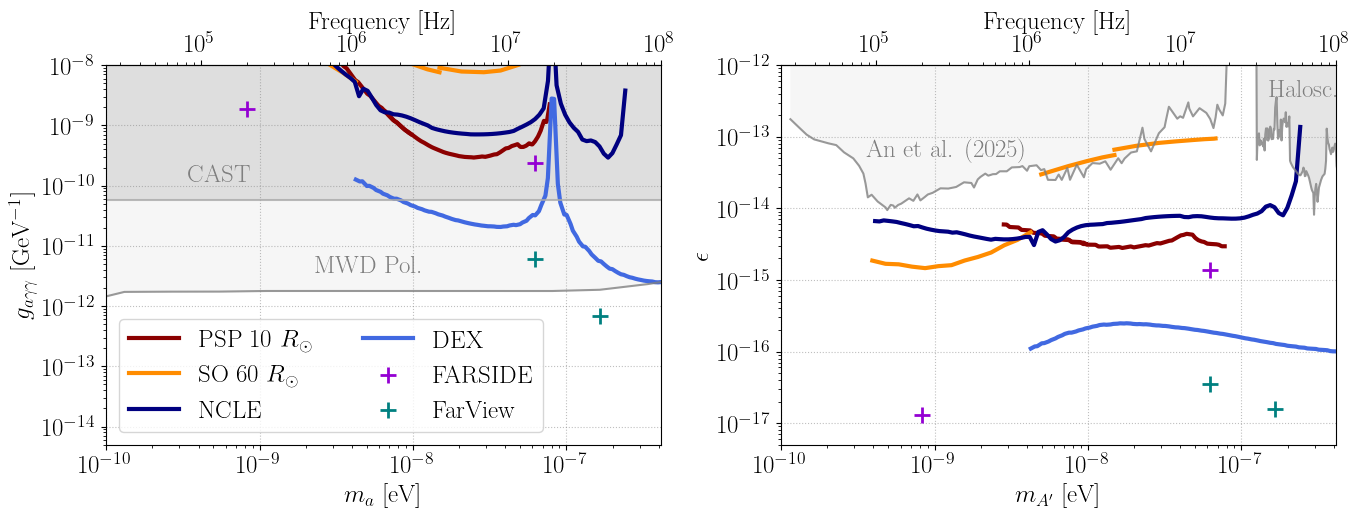

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*fig_width, fig_height), constrained_layout=True)

# ==========================
# ALP panel (ax1)
# ==========================

# In-situ (red/orange)
ax1.plot(x_PSP_LFR_s, g_sens_PSP_LFR_s, color="darkred", lw=1.5*lw_fixed, label=f"PSP {D_PSP / R_sun_meter:.0f} $R_\\odot$")
ax1.plot(x_PSP_HFR_s, g_sens_PSP_HFR_s, color="darkred", lw=1.5*lw_fixed)

# RPW (Solar Orbiter)
ax1.plot(x_RPW_TNR,  g_sens_RPW_TNR,  color="darkorange", lw=1.5*lw_fixed, label=f"SO {D_RPW / R_sun_meter:.0f} $R_\\odot$")
ax1.plot(x_RPW_HFR1_trim, g_sens_RPW_HFR1, color="darkorange", lw=1.5*lw_fixed)
ax1.plot(x_RPW_HFR2, g_sens_RPW_HFR2, color="darkorange", lw=1.5*lw_fixed)

# Lunar (blue tones)
ax1.plot(x_NCLE_all, g_sens_NCLE_sun, color="navy", lw=1.5*lw_fixed, label="NCLE")
ax1.plot(x_DEX, g_sens_DEX_sun, color="royalblue", lw=1.5*lw_fixed, label="DEX")

# Special points
ax1.scatter(x_FAR, g_FAR, marker="+", s=0.9*s_fixed, lw=lw_fixed,
            color="darkviolet", zorder=150, label="FARSIDE")
ax1.scatter(x_FV, g_FV, marker="+", s=0.9*s_fixed, lw=lw_fixed,
            color="teal", zorder=150, label="FarView")

# Axes
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel(r"$m_a$ [eV]")
ax1.set_ylabel(r"$g_{a\gamma\gamma}$ [GeV$^{-1}$]")
ax1.set_xlim(1e-10, freq_to_ma(1e8)); ax1.set_ylim(0.5e-14, 1e-8)
ax1.grid(True, which="major", ls=":", color="gray", alpha=0.5)

# Top axis (frequency)
secax1 = ax1.secondary_xaxis("top", functions=(ma_to_freq, freq_to_ma))
secax1.set_xlabel("Frequency [Hz]")
secax1.set_xscale("log")
secax1.xaxis.set_major_locator(LogLocator(base=10.0))
secax1.xaxis.set_minor_locator(LogLocator(base=10.0, subs="auto", numticks=12))
secax1.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secax1.grid(False)

# Bounds (ALP)
ax1.plot(x_ALP_bounds, y_ALP_bounds, color="grey", alpha=0.8)
ymax_ALP = ax1.get_ylim()[1]
ax1.fill_between(x_ALP_bounds, y_ALP_bounds, ymax_ALP,
                 facecolor="lightgrey", alpha=0.2, linewidth=0, zorder=0)

ax1.plot(x_CAST_bounds, y_CAST_bounds, color="darkgrey", alpha=0.8)
ax1.fill_between(x_CAST_bounds, y_CAST_bounds, ymax_ALP,
                 facecolor="grey", alpha=0.2, linewidth=0, zorder=1)

# Labels
ix_alp = 10
ax1.text(x_ALP_bounds[ix_alp], 4*y_ALP_bounds[ix_alp],
         "MWD Pol.", fontsize=font_size, color="grey",
         ha="left", va="top")

ix_cast = 5
ax1.text(5*x_CAST_bounds[ix_cast], 4*y_CAST_bounds[ix_cast],
         "CAST", fontsize=font_size, color="grey",
         ha="left", va="top")

# ==========================
# DP panel (ax2)
# ==========================

# In-situ (red/orange)
ax2.plot(x_PSP_LFR_s, eps_sens_PSP_LFR_s, color="darkred", lw=1.5*lw_fixed,
         label=f"PSP ({D_PSP / 1.496e11:.3f} AU)")
ax2.plot(x_PSP_HFR_s, eps_sens_PSP_HFR_s, color="darkred", lw=1.5*lw_fixed)

# RPW
ax2.plot(x_RPW_TNR,  eps_sens_RPW_TNR,  color="darkorange", lw=1.5*lw_fixed, label="RPW")
ax2.plot(x_RPW_HFR1_trim, eps_sens_RPW_HFR1, color="darkorange", lw=1.5*lw_fixed)
ax2.plot(x_RPW_HFR2, eps_sens_RPW_HFR2, color="darkorange", lw=1.5*lw_fixed)

# Lunar (blue tones)
ax2.plot(x_NCLE_all, eps_sens_NCLE_sun, color="navy", lw=1.5*lw_fixed, label="NCLE")
ax2.plot(x_DEX, eps_sens_DEX_sun, color="royalblue", lw=1.5*lw_fixed, label="DEX")

# Special points
ax2.scatter(x_FAR, eps_FAR, marker="+", s=0.9*s_fixed, lw=lw_fixed,
            color="darkviolet", zorder=150, label="FARSIDE")
ax2.scatter(x_FV, eps_FV, marker="+", s=0.9*s_fixed, lw=lw_fixed,
            color="teal", zorder=150, label="FarView")

# Axes
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel(r"$m_{A'}$ [eV]")
ax2.set_ylabel(r"$\epsilon$")
ax2.set_xlim(1e-10, freq_to_ma(1e8)); ax2.set_ylim(0.5e-17, 1e-12)
ax2.grid(True, which="major", ls=":", color="gray", alpha=0.5)

# Top axis (frequency)
secax2 = ax2.secondary_xaxis("top", functions=(ma_to_freq, freq_to_ma))
secax2.set_xlabel("Frequency [Hz]")
secax2.set_xscale("log")
secax2.xaxis.set_major_locator(LogLocator(base=10.0))
secax2.xaxis.set_minor_locator(LogLocator(base=10.0, subs="auto", numticks=12))
secax2.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secax2.grid(False)

# Bounds (DP)
ax2.plot(x_DP_bounds, y_DP_bounds, color="grey", alpha=0.8)
ymax_DP = ax2.get_ylim()[1]
ax2.fill_between(x_DP_bounds, y_DP_bounds, ymax_DP,
                 facecolor="lightgrey", alpha=0.2, linewidth=0, zorder=0)

ax2.plot(x_HALO_DP_bounds, y_HALO_DP_bounds, color="grey", alpha=0.8)
ax2.fill_between(x_HALO_DP_bounds, y_HALO_DP_bounds, ymax_DP,
                 facecolor="grey", alpha=0.2, linewidth=0, zorder=0)

# Labels
ix_dp = 10
ax2.text(x_DP_bounds[ix_dp], 2*y_DP_bounds[ix_dp],
         "An et al. (2025)", fontsize=font_size, color="grey",
         ha="left", va="bottom")

ix_halo = 200
ax2.text(1.8e-1*x_HALO_DP_bounds[ix_halo], 4.2*y_HALO_DP_bounds[ix_halo],
         "Halosc.", fontsize=font_size, color="grey",
         ha="left", va="bottom")

# Legend
ax1.legend(frameon=True, loc="lower left", ncol=2)

plt.show()


## **Jupiter**

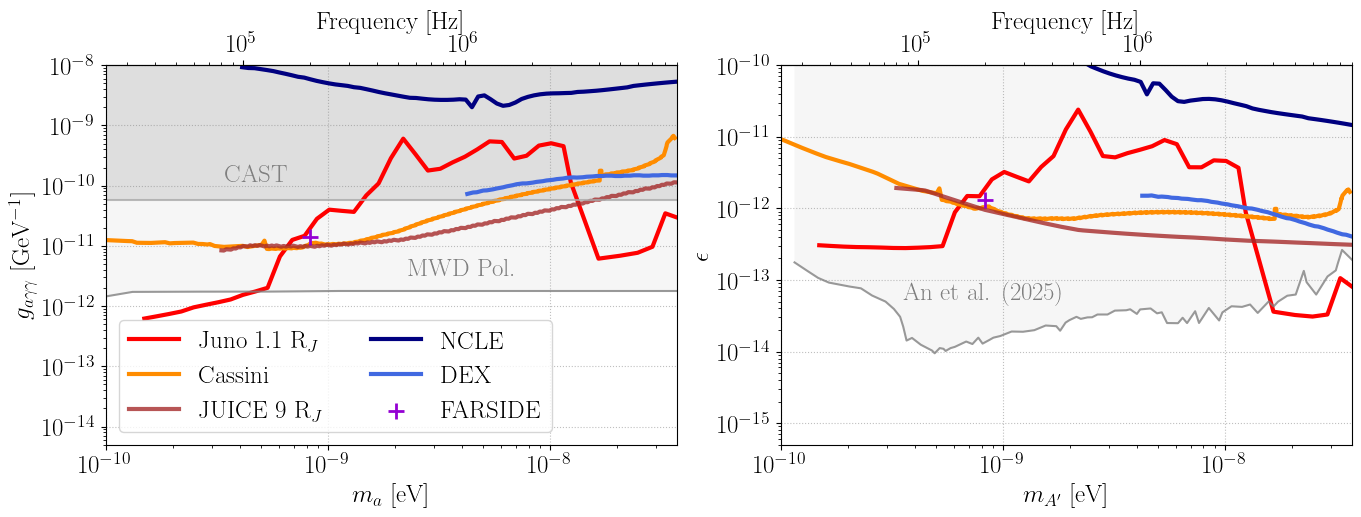

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*fig_width, fig_height), constrained_layout=True)

# ==========================
# ALP panel (ax1)
# ==========================

# In-situ (red/orange)
ax1.plot(x_JUNO_all, g_sens_JUNO_all, color="red", lw=1.5*lw_fixed,
         label=f"Juno {D_JUNO/R_J_meter:.1f} R$_J$")
ax1.plot(x_CASSINI_jupiter, g_sens_CASSINI_jupiter_teff, color="darkorange", lw=1.5*lw_fixed,
         label="Cassini")
ax1.plot(x_JUICE_jupiter, g_sens_JUICE, color="brown", lw=1.5*lw_fixed, alpha=0.8,
         label=f"JUICE {D_JUICE/R_J_meter:.0f} R$_J$")

# Lunar (blue tones)
ax1.plot(x_NCLE_all, g_sens_NCLE_jupiter, color="navy", lw=1.5*lw_fixed, label="NCLE")
ax1.plot(x_DEX, g_sens_DEX_jupiter, color="royalblue", lw=1.5*lw_fixed, label="DEX")

# Special point
ax1.scatter(x_FAR, g_FAR_jupiter, marker="+", s=0.9*s_fixed, lw=lw_fixed,
            color="darkviolet", zorder=150, label="FARSIDE")

# Axes
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel(r"$m_a$ [eV]")
ax1.set_ylabel(r"$g_{a\gamma\gamma}$ [GeV$^{-1}$]")
ax1.set_xlim(1e-10, plasma_freq(1e6)); ax1.set_ylim(0.5e-14, 1e-8)
ax1.grid(True, which="major", ls=":", color="gray", alpha=0.5)

# Top axis (frequency)
secax1 = ax1.secondary_xaxis("top", functions=(ma_to_freq, freq_to_ma))
secax1.set_xlabel("Frequency [Hz]")
secax1.set_xscale("log")
secax1.xaxis.set_major_locator(LogLocator(base=10.0))
secax1.xaxis.set_minor_locator(LogLocator(base=10.0, subs="auto", numticks=12))
secax1.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secax1.grid(False)

# Bounds
ax1.plot(x_ALP_bounds, y_ALP_bounds, color="grey", alpha=0.8)
ymax_ALP = ax1.get_ylim()[1]
ax1.fill_between(x_ALP_bounds, y_ALP_bounds, ymax_ALP,
                 facecolor="lightgrey", alpha=0.2, linewidth=0, zorder=0)

# Label (manual index, like Sun cell)
ix_alp = 10
ax1.text(x_ALP_bounds[ix_alp], 3.5*y_ALP_bounds[ix_alp],
         "MWD Pol.", fontsize=font_size, color="grey",
         ha="left", va="top")

# CAST bounds
ax1.plot(x_CAST_bounds, y_CAST_bounds, color="darkgrey", alpha=0.8)
ax1.fill_between(x_CAST_bounds, y_CAST_bounds, ymax_ALP,
                 facecolor="grey", alpha=0.2, linewidth=0, zorder=1)

# Label (manual index, like Sun cell)
ix_cast = 5
ax1.text(5*x_CAST_bounds[ix_cast], 4*y_CAST_bounds[ix_cast],
         "CAST", fontsize=font_size, color="grey",
         ha="left", va="top")

# ==========================
# DP panel (ax2)
# ==========================

# In-situ (red/orange)
ax2.plot(x_JUNO_all, eps_sens_JUNO_all, color="red", lw=1.5*lw_fixed,
         label=f"JUNO ({D_JUNO/R_J_meter:.1f} R$_J$)")
ax2.plot(x_CASSINI_jupiter, eps_sens_CASSINI_jupiter_teff, color="darkorange", lw=1.5*lw_fixed,
         label="Cassini")
ax2.plot(x_JUICE_jupiter, eps_sens_JUICE, color="brown", lw=1.5*lw_fixed, alpha=0.8)

# Lunar (blue tones)
ax2.plot(x_NCLE_all, eps_sens_NCLE_jupiter, color="navy", lw=1.5*lw_fixed, label="NCLE")
ax2.plot(x_DEX, eps_sens_DEX_jupiter, color="royalblue", lw=1.5*lw_fixed, label="DEX")

# Special point
ax2.scatter(x_FAR, eps_FAR_jupiter, marker="+", s=0.9*s_fixed, lw=lw_fixed,
            color="darkviolet", zorder=150, label="FARSIDE")

# Axes
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel(r"$m_{A'}$ [eV]")
ax2.set_ylabel(r"$\epsilon$")
ax2.set_xlim(1e-10, plasma_freq(1e6)); ax2.set_ylim(5e-16, 1e-10)
ax2.grid(True, which="major", ls=":", color="gray", alpha=0.5)

# Top axis (frequency)
secax2 = ax2.secondary_xaxis("top", functions=(ma_to_freq, freq_to_ma))
secax2.set_xlabel("Frequency [Hz]")
secax2.set_xscale("log")
secax2.xaxis.set_major_locator(LogLocator(base=10.0))
secax2.xaxis.set_minor_locator(LogLocator(base=10.0, subs="auto", numticks=12))
secax2.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secax2.grid(False)

# DP bounds
ax2.plot(x_DP_bounds, y_DP_bounds, color="grey", alpha=0.8)
ymax_DP = ax2.get_ylim()[1]
ax2.fill_between(x_DP_bounds, y_DP_bounds, ymax_DP,
                 facecolor="lightgrey", alpha=0.2, linewidth=0, zorder=0)

# Label (manual index)
ix_dp = 10
ax2.text(x_DP_bounds[ix_dp], 2*y_DP_bounds[ix_dp],
         "An et al. (2025)", fontsize=font_size, color="grey",
         ha="left", va="bottom")

# Legend
ax1.legend(frameon=True, loc="lower left", ncol=2)

plt.show()


## **The Earth**

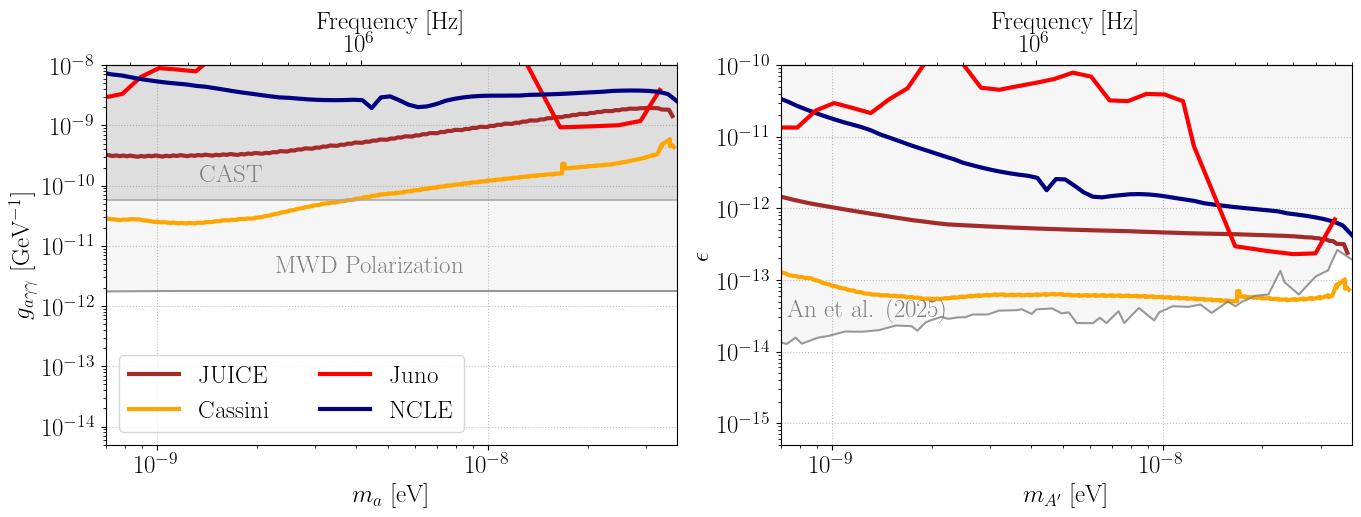

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*fig_width, fig_height), constrained_layout=True)

# ==========================
# ALP panel (ax1)
# ==========================

# Lunar/in-situ (solid)
ax1.plot(x_JUICE_earth,   g_sens_JUICE_earth_teff,   color="brown",  lw=1.5*lw_fixed, label="JUICE")
ax1.plot(x_CASSINI_earth, g_sens_CASSINI_earth_teff, color="orange", lw=1.5*lw_fixed, label="Cassini")
ax1.plot(x_JUNO_all,      g_sens_JUNO_earth_teff,    color="red",    lw=1.5*lw_fixed, label="Juno")
ax1.plot(x_NCLE_all,      g_sens_NCLE_earth,         color="navy",   lw=1.5*lw_fixed, label="NCLE")

# Axes
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel(r"$m_a$ [eV]")
ax1.set_ylabel(r"$g_{a\gamma\gamma}$ [GeV$^{-1}$]")
ax1.set_xlim(7e-10, plasma_freq(1e6)); ax1.set_ylim(0.5e-14, 1e-8)
ax1.grid(True, which="major", ls=":", color="gray", alpha=0.5)

# Top axis (frequency)
secax1 = ax1.secondary_xaxis("top", functions=(ma_to_freq, freq_to_ma))
secax1.set_xlabel("Frequency [Hz]")
secax1.set_xscale("log")
secax1.xaxis.set_major_locator(LogLocator(base=10.0))
secax1.xaxis.set_minor_locator(LogLocator(base=10.0, subs="auto", numticks=12))
secax1.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secax1.grid(False)

# ALP bounds
ax1.plot(x_ALP_bounds, y_ALP_bounds, color="grey", alpha=0.8)
ymax_ALP = ax1.get_ylim()[1]
ax1.fill_between(x_ALP_bounds, y_ALP_bounds, ymax_ALP,
                 facecolor="lightgrey", alpha=0.2, linewidth=0, zorder=0)

# Label (manual index, ALP)
ix_alp = 10
ax1.text(x_ALP_bounds[ix_alp], 4*y_ALP_bounds[ix_alp],
         "MWD Polarization", fontsize=font_size, color="grey",
         ha="left", va="top")

# CAST bounds
ax1.plot(x_CAST_bounds, y_CAST_bounds, color="darkgrey", alpha=0.8)
ax1.fill_between(x_CAST_bounds, y_CAST_bounds, ymax_ALP,
                 facecolor="grey", alpha=0.2, linewidth=0, zorder=1)

# Label (manual index, CAST)
ix_cast = 7
ax1.text(5*x_CAST_bounds[ix_cast], 4*y_CAST_bounds[ix_cast],
         "CAST", fontsize=font_size, color="grey",
         ha="left", va="top")

# ==========================
# DP panel (ax2)
# ==========================

ax2.plot(x_NCLE_all, eps_sens_NCLE_earth, color="navy", lw=1.5*lw_fixed, label="NCLE")
ax2.plot(x_JUICE_earth,   eps_sens_JUICE_earth_teff,   color="brown",  lw=1.5*lw_fixed, label="JUICE")
ax2.plot(x_CASSINI_earth, eps_sens_CASSINI_earth_teff, color="orange", lw=1.5*lw_fixed)
ax2.plot(x_JUNO_all,      eps_sens_JUNO_earth_teff,    color="red",    lw=1.5*lw_fixed)

# Axes
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel(r"$m_{A'}$ [eV]")
ax2.set_ylabel(r"$\epsilon$")
ax2.set_xlim(7e-10, plasma_freq(1e6)); ax2.set_ylim(5e-16, 1e-10)
ax2.grid(True, which="major", ls=":", color="gray", alpha=0.5)

# Top axis (frequency)
secax2 = ax2.secondary_xaxis("top", functions=(ma_to_freq, freq_to_ma))
secax2.set_xlabel("Frequency [Hz]")
secax2.set_xscale("log")
secax2.xaxis.set_major_locator(LogLocator(base=10.0))
secax2.xaxis.set_minor_locator(LogLocator(base=10.0, subs="auto", numticks=12))
secax2.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secax2.grid(False)

# DP bounds
ax2.plot(x_DP_bounds, y_DP_bounds, color="grey", alpha=0.8)
ymax_DP = ax2.get_ylim()[1]
ax2.fill_between(x_DP_bounds, y_DP_bounds, ymax_DP,
                 facecolor="lightgrey", alpha=0.2, linewidth=0, zorder=0)

# Label (manual index, DP)
ix_dp = 10
ax2.text(2.05 * x_DP_bounds[ix_dp], 1.15 * y_DP_bounds[ix_dp],
         "An et al. (2025)", fontsize=font_size, color="grey",
         ha="left", va="bottom")

# Legend
ax1.legend(frameon=True, loc="lower left", ncol=2)

plt.show()
